In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import modules and load data

In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from scipy.stats import entropy

%cd '/content/drive/MyDrive/Colab Notebooks/media-agenda'
import util
from util import DocType, Source, OptimalKClustersConfig

# metadata_file = '/content/drive/MyDrive/Colab Notebooks/media-agenda/data/sentence_cluster_sentiment_dict.json'
metadata_file = '/content/drive/MyDrive/Colab Notebooks/media-agenda/data/sentence_cluster_sentiment_dict_with_cosine_similarity_for_15_clusters.csv'
sid_file = '/content/drive/MyDrive/Colab Notebooks/media-agenda/data/desired_sentence_ids.npy'
rsfile = '/content/drive/My Drive/Colab Notebooks/media-agenda/data/revised_all_sentences_str.json'
rifile = '/content/drive/My Drive/Colab Notebooks/media-agenda/data/revised_all_sentences_ind.json'

%cd '/content/drive/MyDrive/Colab Notebooks/media-agenda/data'

/content/drive/.shortcut-targets-by-id/1jko4SIvsKFTxv155O0DV1wHZ_jS75VfX/Colab Notebooks/media-agenda
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
/content/drive/.shortcut-targets-by-id/1jko4SIvsKFTxv155O0DV1wHZ_jS75VfX/Colab Notebooks/media-agenda/data


In [3]:
# load all sentences
all_sentences = np.array(util.load_sentences(rsfile))

# load sentence id for sentences with character length < 15
desired_sid = np.load(sid_file)
print('Loaded desired id: ', len(desired_sid))

# load sentences assignement as dataframe
# df = pd.read_json(metadata_file)
df = pd.read_csv(metadata_file)
print('Loaded sentence assigments: ', df.shape[0])
display(df.head())

Sentences file - loaded
Done - appended all sentences
Number of tokenized sentences from corpus: 353786
Loaded desired id:  328091
Loaded sentence assigments:  328091


Unnamed: 0  sentence_id  ... textblob_subjectivity  cosine_similarity
0           0            0  ...              0.518182           0.318689
1           1            1  ...              0.675000           0.396096
2           2            2  ...              0.192857           0.537876
3           3            3  ...              0.250000           0.433355
4           4            4  ...              0.291667           0.384546

[5 rows x 11 columns]

In [ ]:
# display(df[(df.source == Source.NYTIMES) & (df.sentiw_sentiment == 0)].shape[0])
# display(df[(df.source == Source.QUORA) & (df.sentiw_sentiment == 0)].shape[0])
# display(df[(df.source == Source.SPIEGEL) & (df.sentiw_sentiment == 0)].shape[0])

# display(df[(df.source == Source.NYTIMES) & (df.textblob_polarity == 0)].shape[0])
# display(df[(df.source == Source.QUORA) & (df.textblob_polarity == 0)].shape[0])
# display(df[(df.source == Source.SPIEGEL) & (df.textblob_subjectivity == 0) & (df.textblob_polarity == 0)].shape[0])
# display(df[(df.source == Source.SPIEGEL) & (df.textblob_polarity == 0)].shape[0])

# display(df[(df.source == Source.NYTIMES) & (df.textblob_subjectivity == 0)].groupby('textblob_polarity').count())
# display(df[(df.source == Source.QUORA) & (df.textblob_subjectivity == 0)].groupby('textblob_polarity').count())
# display(df[(df.source == Source.SPIEGEL) & (df.textblob_subjectivity == 0)].groupby('textblob_polarity').count())

In [ ]:
nytimes = pd.read_json('/content/drive/My Drive/Colab Notebooks/media-agenda/data/media-agenda-dataset-quora/nytimes.json')
spiegel = pd.read_json('/content/drive/My Drive/Colab Notebooks/media-agenda/data/media-agenda-dataset-quora/spiegel.json')
quora = pd.read_json('/content/drive/My Drive/Colab Notebooks/media-agenda/data/media-agenda-dataset-quora/quora.json')

nytimes = nytimes[nytimes['relevant'] == 1.0]
spiegel = spiegel[spiegel['relevant'] == 1.0]
quora = quora[quora['relevant'] == 1.0]

In [ ]:
print(len(nytimes), len(quora), len(spiegel))
print(df[df.source == Source.NYTIMES].article_id.max(), df[df.source == Source.QUORA].article_id.max(), df[df.source == Source.SPIEGEL].article_id.max())

327 1497 152
326 1496 151


## Calculate entropy for each article (with textblob.polarity == 0 filtered)
* by averaging entropies of its article sentences and comment sentences
* entropy for each section (either article or comment section) would be 0 if
  1. no sentences at all
  2. all the sentences in the section are assigned into the same topic

In [ ]:
assert entropy([0.5, 0.5], axis = 0) == entropy([0.5, 0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], axis = 0)

In [ ]:
import warnings

entropy_results = []

sources = [Source.NYTIMES, Source.QUORA, Source.SPIEGEL]

with warnings.catch_warnings():
  warnings.filterwarnings('ignore', r'invalid value encountered in true_divide')
  for source in sources:
    print('Started for {} articles'.format(source))
    sub_df = df[(df.source == source) & (df.textblob_polarity != 0)]
    article_df = df[(df.source == source) & (df.textblob_polarity != 0) & (df.comment_id == DocType.NON_COMMENT.value)]
    comment_df = df[(df.source == source) & (df.textblob_polarity != 0) & (df.comment_id != DocType.NON_COMMENT.value)]

    unique_article_ids = sub_df.article_id.unique()
    # num_of_article = len(article_df.article_id.unique())
    # num_of_article_with_comment = len(comment_df.article_id.unique())
    # print('For {}: {} articles, {} with comments'.format(source, num_of_article, num_of_article_with_comment))

    print('Total:', len(unique_article_ids))
    # print(unique_article_ids[-1])
    # print(sub_df.article_id.max())
    # assert total_articles == sub_df.article_id.max() + 1

    cluster_df = pd.DataFrame({'cluster': range(OptimalKClustersConfig.k_with_garbage)})

    for article_id in unique_article_ids:
      # print(article_id)
      # display(article_df[article_df.article_id == article_id].groupby('cluster').sentence_id.count().reset_index().merge(cluster_df, how = 'right', on = 'cluster', validate = '1:1').fillna(0))
      article_sentence_counts = article_df[article_df.article_id == article_id].groupby('cluster').sentence_id.count().reset_index().merge(cluster_df, how = 'right', on = 'cluster', validate = '1:1').fillna(0).sentence_id.values
      article_sentence_distribution = article_sentence_counts / article_sentence_counts.sum()
      comment_sentence_counts = comment_df[comment_df.article_id == article_id].groupby('cluster').sentence_id.count().reset_index().merge(cluster_df, how = 'right', on = 'cluster', validate = '1:1').fillna(0).sentence_id.values
      comment_sentence_distribution = comment_sentence_counts / comment_sentence_counts.sum()

      article_entropy = entropy(article_sentence_distribution, axis = 0)
      comment_entropy = entropy(comment_sentence_distribution, axis = 0)
      average_entropy = np.mean([article_entropy, comment_entropy])

      # print('here')
      # print(article_entropy, article_sentence_counts, article_sentence_distribution)
      # print(comment_entropy, comment_sentence_counts, comment_sentence_distribution)
      # print('end')

      entropy_results.append((source, article_id, article_entropy, comment_entropy, average_entropy, article_sentence_counts.sum(), comment_sentence_counts.sum(), np.round(article_sentence_distribution, 2), np.round(comment_sentence_distribution, 2)))
      if article_id == sub_df.article_id.max():
        print('Completed for {} {} articles'.format(len(unique_article_ids), source))
      # break

# entropy_df = pd.DataFrame(entropy_results, columns = ['source', 'article_id', 'article_entropy', 'comment_entropy', 'average_entropy', 'article_sentence_count', 'comment_sentence_count', 'article_sentence_distribution', 'comment_sentence_distribution'])
# entropy_df

Started for nytimes articles
Total: 327
Completed for 327 nytimes articles
Started for quora articles
Total: 1294
Completed for 1294 quora articles
Started for spiegel articles
Total: 151
Completed for 151 spiegel articles


In [ ]:
entropy_df = pd.DataFrame(entropy_results, columns = ['source', 'article_id', 'article_entropy', 'comment_entropy', 'average_entropy', 'article_sentence_count', 'comment_sentence_count', 'article_sentence_distribution', 'comment_sentence_distribution'])
entropy_df = entropy_df.sort_values('average_entropy', ascending = False)

entropy_df.to_csv('entropies_for_articles_with_15_clusters.csv')
entropy_df.head()

source  ...                      comment_sentence_distribution
243   nytimes  ...  [0.15, 0.07, 0.09, 0.01, 0.0, 0.12, 0.02, 0.06...
1679  spiegel  ...  [0.06, 0.04, 0.07, 0.12, 0.0, 0.07, 0.03, 0.08...
1692  spiegel  ...  [0.09, 0.03, 0.06, 0.09, 0.0, 0.04, 0.04, 0.11...
322   nytimes  ...  [0.07, 0.02, 0.04, 0.25, 0.0, 0.03, 0.04, 0.11...
97    nytimes  ...  [0.08, 0.11, 0.1, 0.03, 0.0, 0.07, 0.0, 0.07, ...

[5 rows x 9 columns]

## Article based analysis (with textblob.polarity == 0 filtered)
* Sentences from garbage

### Functions

In [ ]:
def boxplot(sub_df, article_id, source, magnified = False):
  
  factor = 5 if magnified else 1
  data = []
  weights = []
  titles = ['Overall'] + OptimalKClustersConfig.clusters
  k = len(titles)
  
  def get_data_tuple(df):

    return (df[(df.comment_id != DocType.NON_COMMENT.value)].textblob_polarity,
            df[(df.comment_id == DocType.NON_COMMENT.value)].textblob_polarity)

  # data for overall
  data.append(get_data_tuple(sub_df))
  weights.append((1 * factor, 1 * factor))
  # weights.append((1 * factor, 1 * factor, 1 * factor, 1* factor))

  # data for each cluster
  for i in range(OptimalKClustersConfig.k_with_garbage):
    if i not in OptimalKClustersConfig.garbage_clusters:
      tuple = get_data_tuple(sub_df[sub_df.cluster == i])
      data.append(tuple)
      weights.append((tuple[0].shape[0] / data[0][0].shape[0] * factor, 
                      tuple[1].shape[0] / data[0][1].shape[0] * factor))

  # colormap
  colors = ['red', 'lightgrey', 'green']
  # colors = ['red', 'white', 'green']
  cmap = LinearSegmentedColormap.from_list('sentiment', colors, N = 100)
  norm = mpl.colors.Normalize(vmin = -0.1, vmax = 0.1) if magnified else mpl.colors.Normalize(vmin = -1, vmax = 1) 

  # figure
  plt.style.use('ggplot')
  fig, axs = plt.subplots(13, 1, figsize = (8, 24), num = 'ggplot')
  # st = fig.suptitle('Distribution of ' + senti_choice + ' for ' + str.upper(source))
  st = fig.suptitle('Distribution of sentiments for ' + str.upper(source))

  for i in range(len(data)):
    box = axs[i].boxplot(data[i], widths = weights[i], vert = False, showmeans = True, patch_artist = True)
    axs[i].set_title(titles[i], color = 'grey')
    axs[i].set_xlim((-1.05, 1.05))
    axs[i].set_ylim((-0.05, 3.05))
    # axs[i].set_yticklabels(['Comment', 'Article'])
    # axs[i].set_ylim((-0.05, 5.05))
    # axs[i].set_yticklabels(['Textblob Comment', 'Textblob Article', 'SentiWordNet Comment', 'SentiWordNet Article'])
    axs[i].set_yticklabels(['Textblob Comment', 'Textblob Article'])
    axs[i].set(xlabel = 'Sentiment')
    axs[i].vlines(x = 0, ymin = -0.05, ymax = 3.05, linestyles = 'dotted', color = 'red')


    colors = [cmap(norm(np.mean(data[i][0]))), cmap(norm(np.mean(data[i][1])))]
    # colors = [cmap(norm(np.mean(data[i][0]))), cmap(norm(np.mean(data[i][1]))), cmap(norm(np.mean(data[i][2]))), cmap(norm(np.mean(data[i][3])))]

    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

  if magnified:
    axs[0].set_ylim((-4, 8))

  # Hide x labels and tick labels for top plots and y ticks for right plots.
  for ax in axs.flat:
      ax.label_outer()
  st.set_y(0.9)

  # color bar   #https://stackoverflow.com/questions/40227283/setting-the-size-of-a-matplotlib-colorbarbase-object
  cb1 = mpl.colorbar.ColorbarBase(axs[12], cmap = cmap, norm = norm, orientation = 'horizontal', label = 'Sentiment')
  plt.subplots_adjust(hspace = 0.5)
  plt.show()

  # if magnified:
  #   fig.savefig('boxplot_for_' + source + '_magnified.pdf') 
  #   # fig.savefig('boxplot_for_' + senti_choice + '_' + source + '_magnified.pdf') 
  # else:
  #   fig.savefig('boxplot_for_' + source + '.pdf') 


In [ ]:
def displot(df):
  g = sns.FacetGrid(df, col = 'doc_type', hue = 'topic')
  g.map(sns.histplot, 'cosine_similarity', bins = 10)
  g.set(xlim=(0, 1))
  g.add_legend()

In [ ]:
def get_topic_distribution_by_article(source, article_id):
  sub_df = df[(df.source == source) & (df.textblob_polarity != 0)]
  article_df = df[(df.source == source) & (df.textblob_polarity != 0) & (df.comment_id == DocType.NON_COMMENT.value)]
  comment_df = df[(df.source == source) & (df.textblob_polarity != 0) & (df.comment_id != DocType.NON_COMMENT.value)]

  num_of_article = len(article_df.article_id.unique())
  num_of_article_with_comment = len(comment_df.article_id.unique())
  print('For {}: {} articles, {} with comments'.format(source, num_of_article, num_of_article_with_comment))

  # optimal_clusters_df = pd.DataFrame({'cluster': OptimalKClustersConfig.valid_cluster_index,
  #                                     'topic': OptimalKClustersConfig.clusters}) 

  cluster_label_for_15 = ['Planting and gardening: {pesticid, plant, pflanz, pestizid}', 'Retail', 'Garbage: {http, www, http, de}', 'GMO label and bio-products',
                        'Garbage: {www, articl, sysop, michaelis}', 'Taste and food', 'Chemicals and cancer: {cancer, chemic, bodi, dioxin}', 'Genetic research', 
                        'Health and diet', 'Garbage: {thank, here, all, mich}', 'Governance and public policy', 'Meat and animal feeding', 
                        'Agriculture', 'Price and consumption', 'Garbage: {articl, question, verscharft, tragt}']

  optimal_clusters_df = pd.DataFrame({'cluster': range(OptimalKClustersConfig.k_with_garbage),
                                      'topic': cluster_label_for_15}) 
  
  
  # print('Optimal clusters for k = 15')
  # display(optimal_clusters_df)

  if article_id != None: 

    result_df = pd.DataFrame({'article_sentence_count': article_df[article_df.article_id == article_id].groupby('cluster').sentence_id.count(),
                              'article_sentiment_median': article_df[article_df.article_id == article_id].groupby('cluster').textblob_polarity.median(),
                              'article_sentiment_iqr': article_df[article_df.article_id == article_id].groupby('cluster').textblob_polarity.quantile(0.75) - article_df[article_df.article_id == article_id].groupby('cluster').textblob_polarity.quantile(0.25),
                              'comment_sentence_count': comment_df[comment_df.article_id == article_id].groupby('cluster').sentence_id.count(),
                              'comment_sentiment_median': comment_df[comment_df.article_id == article_id].groupby('cluster').textblob_polarity.median(),
                              'comment_sentiment_iqr': comment_df[comment_df.article_id == article_id].groupby('cluster').textblob_polarity.quantile(0.75) - comment_df[comment_df.article_id == article_id].groupby('cluster').textblob_polarity.quantile(0.25),
                              'article_sentence_id_list': article_df[article_df.article_id == article_id].groupby('cluster').sentence_id.apply(list),
                              'comment_sentence_id_list': comment_df[comment_df.article_id == article_id].groupby('cluster').sentence_id.apply(list)
                              }).reset_index()
                  
    result_df = optimal_clusters_df.merge(result_df, how = 'left', validate = 'one_to_one')

    display(result_df)

    article_result_df = result_df[(pd.notna(result_df.article_sentence_count))]
    comment_result_df = result_df[(pd.notna(result_df.comment_sentence_count))]

    clustered_sentences = []
    # for i in OptimalKClustersConfig.valid_cluster_index:
    for i in range(OptimalKClustersConfig.k_with_garbage):
      if not article_result_df[article_result_df.cluster == i].empty:
        article_sentence_indeces = np.concatenate(article_result_df[article_result_df.cluster == i].article_sentence_id_list.values).ravel()
        for j in article_sentence_indeces:
          clustered_sentences.append((source, 
                                      article_id,
                                      'article sentence', 
                                      i,
                                      # OptimalKClustersConfig.clusters_with_garbage[i], 
                                      cluster_label_for_15[i],
                                      all_sentences[j],
                                      df[df.sentence_id == j]['sentence_id'].values[0],
                                      df[df.sentence_id == j].cosine_similarity.values[0]))
          
      if not comment_result_df[comment_result_df.cluster == i].empty:
        comment_sentence_indeces = np.concatenate(comment_result_df[comment_result_df.cluster == i].comment_sentence_id_list.values).ravel()
        for k in comment_sentence_indeces:
          clustered_sentences.append((source, 
                                    article_id,
                                    'comment sentence', 
                                    i,
                                    # OptimalKClustersConfig.clusters_with_garbage[i],
                                    cluster_label_for_15[i],
                                    all_sentences[k],
                                    df[df.sentence_id == k]['sentence_id'].values[0],
                                    df[df.sentence_id == k]['cosine_similarity'].values[0]))
    
    clustered_sentences_df = pd.DataFrame(clustered_sentences, columns = ['source', 'article_id', 'doc_type', 'cluster', 'topic', 'sentence', 'sentence_id', 'cosine_similarity'])
    pd.set_option('display.max_rows', None, 'display.max_colwidth', None)
    displot(clustered_sentences_df)
    display(clustered_sentences_df.sort_values(by = 'cosine_similarity', ascending = False).sort_values(by = ['cluster', 'doc_type']))

    boxplot(sub_df[sub_df.article_id == article_id], article_id, source, magnified = True)


## Chemical and cancer

### NYTIMES - 264

In [ ]:
article_id = 264
display(nytimes.iloc[article_id].article_title)
display(nytimes.iloc[article_id].article_url)

'New Alarm Bells About Chemicals and Cancer'

'http://www.nytimes.com/2010/05/06/opinion/06kristof.html'

For nytimes: 327 articles, 99 with comments


cluster  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           comment_sentence_id_list
0         0  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 [53595, 53656, 53707, 53784, 53841, 53842, 53853, 53872, 54017, 54018, 54031, 54032, 54198, 54300, 54352, 54353, 54357, 54458, 54506, 54544, 54552, 54565, 54566, 54569, 54593, 54595, 54608, 54731, 54741, 54745]
1         1  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 [53823, 53834, 53840, 53870, 54060, 54145, 54201, 54202, 54267, 54269, 54270, 54543, 54638, 54721]
2         2  ...                                                                                                                                                                                                                                                                                                                                                                     [53606, 53624, 53635, 53643, 53661, 53678, 53716, 53746, 53754, 53772, 53838, 53849, 53866, 53885, 53952, 53962, 54014, 54035, 54050, 54065, 54100, 54207, 54216, 54237, 54238, 54239, 54242, 54309, 54311, 54322, 54358, 54404, 54468, 54501, 54510, 54522, 54537, 54562, 54568, 54570, 54576, 54605, 54637, 54687, 54722, 54733, 54751, 54753, 54764, 54791]
3         3  ...                                                                                                                                                                                                                                                                                                                    [53603, 53626, 53638, 53652, 53667, 53694, 53732, 53738, 53796, 53803, 53820, 53828, 53847, 53851, 53857, 53858, 53874, 53906, 53998, 54001, 54006, 54009, 54068, 54069, 54071, 54174, 54176, 54177, 54214, 54215, 54247, 54263, 54274, 54307, 54333, 54334, 54391, 54395, 54446, 54455, 54478, 54480, 54491, 54508, 54545, 54550, 54613, 54634, 54635, 54651, 54660, 54676, 54719, 54720, 54762, 54782, 54784]
4         4  ...                                                                                                                                                                                                                                                                                                                                                                                

source  article_id  ... sentence_id  cosine_similarity
15   nytimes         264  ...       54353           0.597155
12   nytimes         264  ...       54198           0.546668
19   nytimes         264  ...       54544           0.546280
20   nytimes         264  ...       54552           0.545757
6    nytimes         264  ...       53853           0.534714
11   nytimes         264  ...       54032           0.513007
10   nytimes         264  ...       54031           0.512867
29   nytimes         264  ...       54745           0.510940
5    nytimes         264  ...       53842           0.507546
13   nytimes         264  ...       54300           0.502657
21   nytimes         264  ...       54565           0.487724
28   nytimes         264  ...       54741           0.486104
16   nytimes         264  ...       54357           0.478361
0    nytimes         264  ...       53595           0.475626
7    nytimes         264  ...       53872           0.473623
25   nytimes         264  ...       54595           0.458768
14   nytimes         264  ...       54352           0.444393
18   nytimes         264  ...       54506           0.438655
23   nytimes         264  ...       54569           0.430639
1    nytimes         264  ...       53656           0.429058
3    nytimes         264  ...       53784           0.415840
27   nytimes         264  ...       54731           0.407194
2    nytimes         264  ...       53707           0.390691
24   nytimes         264  ...       54593           0.388393
17   nytimes         264  ...       54458           0.371556
8    nytimes         264  ...       54017           0.369241
22   nytimes         264  ...       54566           0.357183
4    nytimes         264  ...       53841           0.347846
26   nytimes         264  ...       54608           0.342122
9    nytimes         264  ...       54018           0.329498
39   nytimes         264  ...       54269           0.405477
35   nytimes         264  ...       54145           0.379828
37   nytimes         264  ...       54202           0.360680
36   nytimes         264  ...       54201           0.357160
41   nytimes         264  ...       54543           0.348082
30   nytimes         264  ...       53823           0.343438
42   nytimes         264  ...       54638           0.334898
40   nytimes         264  ...       54270           0.321039
31   nytimes         264  ...       53834           0.311876
43   nytimes         264  ...       54721           0.287219
38   nytimes         264  ...       54267           0.251598
34   nytimes         264  ...       54060           0.233084
32   nytimes         264  ...       53840           0.211935
33   nytimes         264  ...       53870           0.208321
44   nytimes         264  ...       53565           0.080550
75   nytimes         264  ...       54358           0.144583
87   nytimes         264  ...       54637           0.143373
62   nytimes         264  ...       54035           0.143284
92   nytimes         264  ...       54753           0.143211
59   nytimes         264  ...       53952           0.139844
65   nytimes         264  ...       54100           0.132243
86   nytimes         264  ...       54605           0.129400
73   nytimes         264  ...       54311           0.126781
48   nytimes         264  ...       53643           0.114775
52   nytimes         264  ...       53746           0.112133
49   nytimes         264  ...       53661           0.109165
51   nytimes         264  ...       53716           0.106282
72   nytimes         264  ...       54309           0.106174
61   nytimes         264  ...       54014           0.104527
54   nytimes         264  ...       53772           0.103886
81   nytimes         264  ...       54537           0.100336
84   nytimes         264  ...       54570           0.098226
82   nytimes         264  ...       54562           0.097925
57   nytimes         264  ...       53866           0.095901
67   nytimes         264  ...       54216

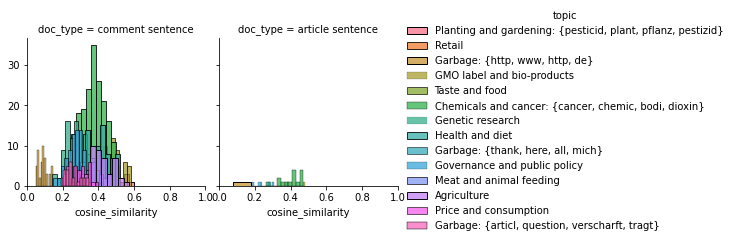

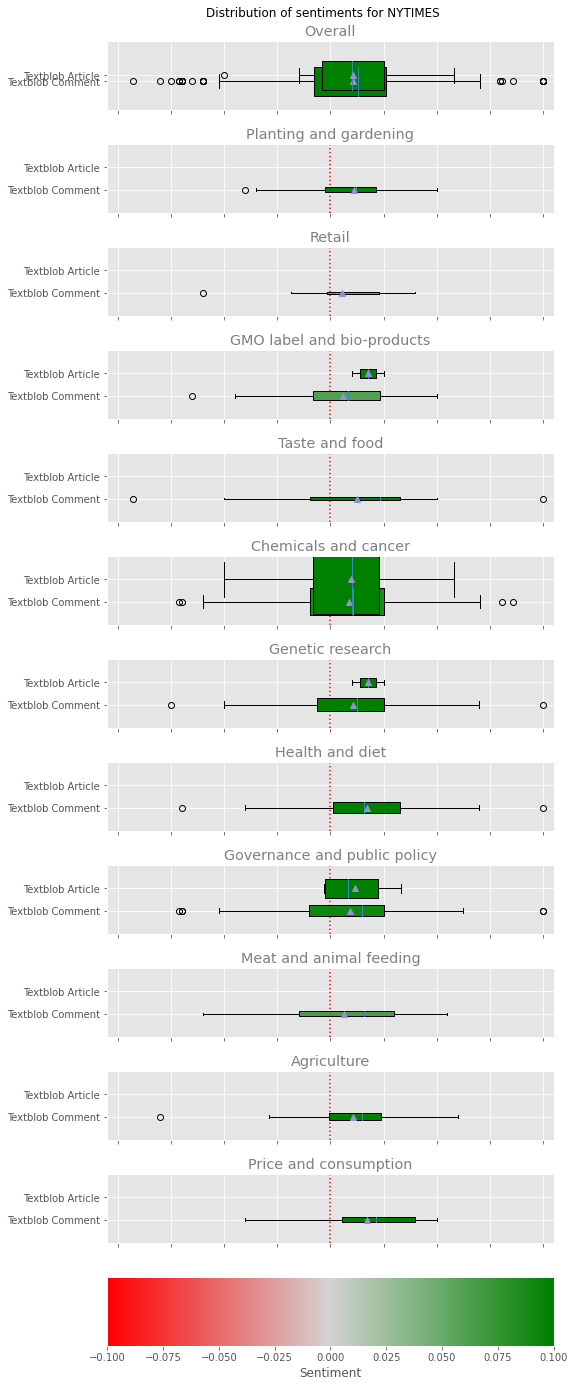

In [ ]:
# magnified = True
get_topic_distribution_by_article(source = Source.NYTIMES, article_id = article_id)

For nytimes: 327 articles, 99 with comments


cluster  ...                           comment_sentence_id_list
0         0  ...  [53595, 53656, 53707, 53784, 53841, 53842, 538...
1         1  ...  [53823, 53834, 53840, 53870, 54060, 54145, 542...
2         2  ...  [53606, 53624, 53635, 53643, 53661, 53678, 537...
3         3  ...  [53603, 53626, 53638, 53652, 53667, 53694, 537...
4         4  ...                                                NaN
5         5  ...  [53714, 53786, 53839, 53875, 53956, 54055, 540...
6         6  ...  [53637, 53646, 53649, 53653, 53655, 53657, 536...
7         7  ...  [53604, 53620, 53629, 53631, 53650, 53658, 536...
8         8  ...  [53639, 53662, 53671, 53684, 53687, 53692, 536...
9         9  ...  [53679, 53720, 53886, 53954, 53972, 54094, 541...
10       10  ...  [53597, 53600, 53601, 53602, 53609, 53619, 536...
11       11  ...  [53711, 53712, 53759, 53760, 53761, 53762, 538...
12       12  ...  [53614, 53644, 53674, 53685, 53745, 53844, 538...
13       13  ...  [53617, 53618, 53632, 53676, 53729, 53774, 537...
14       14  ...  [53615, 53668, 53669, 53704, 53748, 53791, 538...

[15 rows x 10 columns]

source  article_id  ... sentence_id  cosine_similarity
15   nytimes         264  ...       54353           0.597155
12   nytimes         264  ...       54198           0.546668
19   nytimes         264  ...       54544           0.546280
20   nytimes         264  ...       54552           0.545757
6    nytimes         264  ...       53853           0.534714
11   nytimes         264  ...       54032           0.513007
10   nytimes         264  ...       54031           0.512867
29   nytimes         264  ...       54745           0.510940
5    nytimes         264  ...       53842           0.507546
13   nytimes         264  ...       54300           0.502657
21   nytimes         264  ...       54565           0.487724
28   nytimes         264  ...       54741           0.486104
16   nytimes         264  ...       54357           0.478361
0    nytimes         264  ...       53595           0.475626
7    nytimes         264  ...       53872           0.473623
25   nytimes         264  ...       54595           0.458768
14   nytimes         264  ...       54352           0.444393
18   nytimes         264  ...       54506           0.438655
23   nytimes         264  ...       54569           0.430639
1    nytimes         264  ...       53656           0.429058
3    nytimes         264  ...       53784           0.415840
27   nytimes         264  ...       54731           0.407194
2    nytimes         264  ...       53707           0.390691
24   nytimes         264  ...       54593           0.388393
17   nytimes         264  ...       54458           0.371556
8    nytimes         264  ...       54017           0.369241
22   nytimes         264  ...       54566           0.357183
4    nytimes         264  ...       53841           0.347846
26   nytimes         264  ...       54608           0.342122
9    nytimes         264  ...       54018           0.329498
39   nytimes         264  ...       54269           0.405477
35   nytimes         264  ...       54145           0.379828
37   nytimes         264  ...       54202           0.360680
36   nytimes         264  ...       54201           0.357160
41   nytimes         264  ...       54543           0.348082
30   nytimes         264  ...       53823           0.343438
42   nytimes         264  ...       54638           0.334898
40   nytimes         264  ...       54270           0.321039
31   nytimes         264  ...       53834           0.311876
43   nytimes         264  ...       54721           0.287219
38   nytimes         264  ...       54267           0.251598
34   nytimes         264  ...       54060           0.233084
32   nytimes         264  ...       53840           0.211935
33   nytimes         264  ...       53870           0.208321
44   nytimes         264  ...       53565           0.080550
75   nytimes         264  ...       54358           0.144583
87   nytimes         264  ...       54637           0.143373
62   nytimes         264  ...       54035           0.143284
92   nytimes         264  ...       54753           0.143211
59   nytimes         264  ...       53952           0.139844
65   nytimes         264  ...       54100           0.132243
86   nytimes         264  ...       54605           0.129400
73   nytimes         264  ...       54311           0.126781
48   nytimes         264  ...       53643           0.114775
52   nytimes         264  ...       53746           0.112133
49   nytimes         264  ...       53661           0.109165
51   nytimes         264  ...       53716           0.106282
72   nytimes         264  ...       54309           0.106174
61   nytimes         264  ...       54014           0.104527
54   nytimes         264  ...       53772           0.103886
81   nytimes         264  ...       54537           0.100336
84   nytimes         264  ...       54570           0.098226
82   nytimes         264  ...       54562           0.097925
57   nytimes         264  ...       53866           0.095901
67   nytimes         264  ...       54216

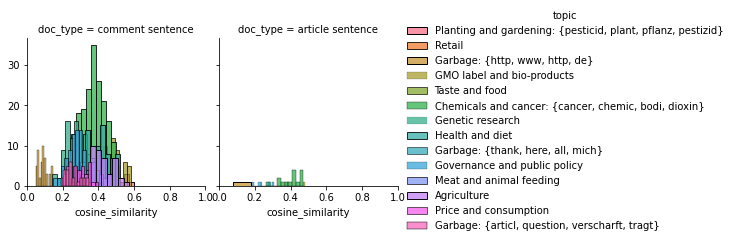

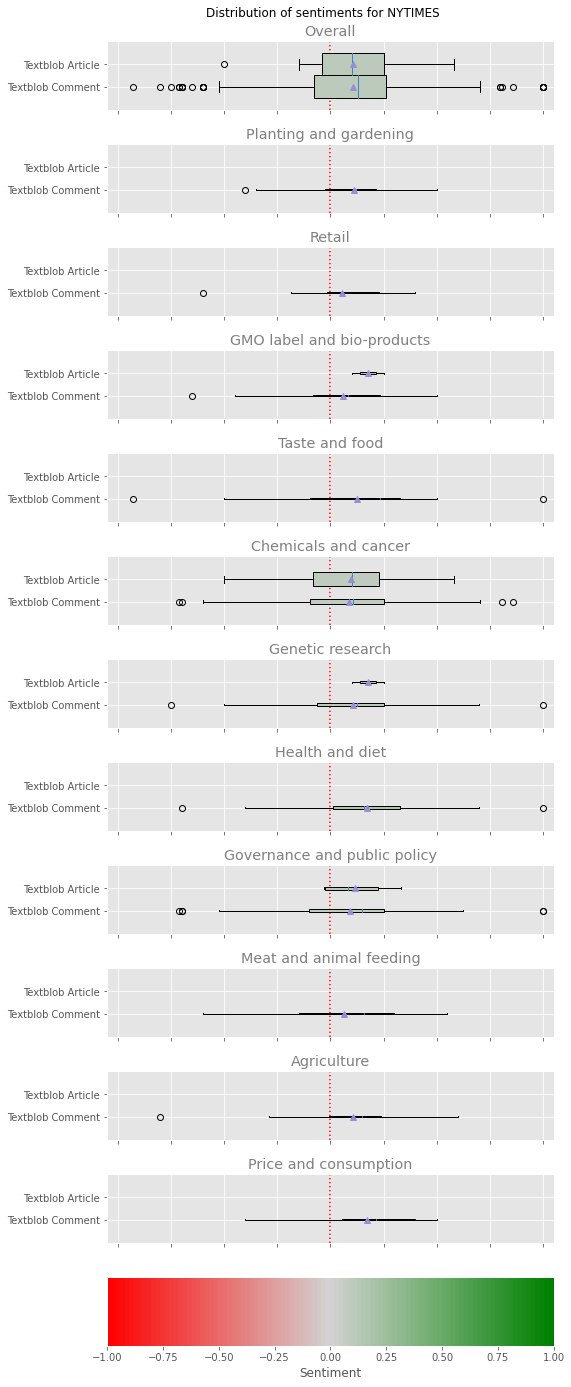

In [ ]:
# magnified = False
get_topic_distribution_by_article(source = Source.NYTIMES, article_id = article_id)

### SPIEGEL - 112

In [ ]:
article_id = 112
print(spiegel.iloc[article_id].article_title)
print(spiegel.iloc[article_id].article_url)

Dioxin | Die wichtigsten Fragen und Antworten zum Gift-Skandal
http://www.spiegel.de/wissenschaft/medizin/dioxin-die-wichtigsten-fragen-und-antworten-zum-gift-skandal-a-737972.html


In [ ]:
get_topic_distribution_by_article(source = Source.SPIEGEL, article_id = article_id)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
get_topic_distribution_by_article(source = Source.SPIEGEL, article_id = article_id)

Output hidden; open in https://colab.research.google.com to view.

## Retail

### NYTIMES - 102

In [ ]:
article_id = 102
display(nytimes.iloc[article_id].article_title)
display(nytimes.iloc[article_id].article_url)

'An Upscale Bounty, and a Thankful Shopper'

'http://www.nytimes.com/2013/11/23/business/an-upscale-bounty-and-a-thankful-shopper.html'

For nytimes: 327 articles, 99 with comments


cluster  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           comment_sentence_id_list
0         0  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     [13013, 13014]
1         1  ...  [12857, 12862, 12864, 12865, 12870, 12877, 12878, 12880, 12882, 12883, 12892, 12905, 12907, 12909, 12919, 12921, 12924, 12926, 12929, 12931, 12932, 12933, 12936, 12938, 12945, 12947, 12949, 12950, 12951, 12952, 12953, 12954, 12955, 12956, 12957, 12960, 12961, 12962, 12964, 12969, 12970, 12974, 12975, 12976, 12977, 12978, 12981, 12982, 12983, 12986, 12988, 12990, 12991, 12992, 12995, 12997, 13000, 13001, 13004, 13005, 13007, 13009, 13018, 13020, 13025, 13026, 13031, 13032, 13035, 13037, 13040, 13047, 13048, 13049, 13055, 13062, 13064, 13065, 13066, 13067, 13068, 13069, 13070, 13071, 13072, 13074, 13076, 13078, 13079, 13081, 13086, 13089, 13094, 13099, 13103, 13104, 13105, 13106, 13107, 13109, ...]
2         2  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       [12861, 12866, 12869, 12912, 12940, 12942, 12946, 12993, 12996, 12999, 13002, 13033, 13059, 13080, 13093, 13112, 13114, 13123, 13131, 13132]
3         3  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            [13042]
4         4  ...                                                                                                                                                                                                                                                                                                                                                                                

source  article_id  ... sentence_id  cosine_similarity
0    nytimes         102  ...       13013           0.524557
1    nytimes         102  ...       13014           0.512852
2    nytimes         102  ...       12755           0.463736
6    nytimes         102  ...       12763           0.458593
3    nytimes         102  ...       12757           0.451803
32   nytimes         102  ...       12835           0.450887
23   nytimes         102  ...       12810           0.446400
27   nytimes         102  ...       12815           0.443742
21   nytimes         102  ...       12807           0.443159
26   nytimes         102  ...       12814           0.436409
7    nytimes         102  ...       12769           0.432588
10   nytimes         102  ...       12776           0.420708
24   nytimes         102  ...       12811           0.419909
30   nytimes         102  ...       12826           0.413479
25   nytimes         102  ...       12813           0.412637
36   nytimes         102  ...       12844           0.403851
12   nytimes         102  ...       12785           0.394182
31   nytimes         102  ...       12833           0.390631
35   nytimes         102  ...       12842           0.390048
15   nytimes         102  ...       12794           0.377574
33   nytimes         102  ...       12836           0.377139
5    nytimes         102  ...       12762           0.369742
17   nytimes         102  ...       12798           0.368309
13   nytimes         102  ...       12786           0.365750
34   nytimes         102  ...       12838           0.365554
19   nytimes         102  ...       12805           0.360971
18   nytimes         102  ...       12804           0.352857
29   nytimes         102  ...       12825           0.346828
38   nytimes         102  ...       12850           0.345164
28   nytimes         102  ...       12819           0.339125
11   nytimes         102  ...       12780           0.337392
14   nytimes         102  ...       12789           0.330764
16   nytimes         102  ...       12796           0.328024
22   nytimes         102  ...       12809           0.316153
20   nytimes         102  ...       12806           0.312904
8    nytimes         102  ...       12774           0.312639
9    nytimes         102  ...       12775           0.285096
4    nytimes         102  ...       12761           0.279883
37   nytimes         102  ...       12849           0.216049
71   nytimes         102  ...       12955           0.501446
73   nytimes         102  ...       12957           0.474529
115  nytimes         102  ...       13064           0.468138
50   nytimes         102  ...       12905           0.463821
56   nytimes         102  ...       12926           0.452713
97   nytimes         102  ...       13004           0.445395
138  nytimes         102  ...       13109           0.438771
123  nytimes         102  ...       13072           0.435094
75   nytimes         102  ...       12961           0.431974
90   nytimes         102  ...       12990           0.429793
46   nytimes         102  ...       12880           0.427555
140  nytimes         102  ...       13113           0.425501
109  nytimes         102  ...       13040           0.423187
41   nytimes         102  ...       12864           0.420640
74   nytimes         102  ...       12960           0.418895
119  nytimes         102  ...       13068           0.417579
99   nytimes         102  ...       13007           0.417187
106  nytimes         102  ...       13032           0.412926
133  nytimes         102  ...       13103           0.411676
101  nytimes         102  ...       13018           0.409837
40   nytimes         102  ...       12862           0.409732
59   nytimes         102  ...       12932           0.407856
116  nytimes         102  ...       13065           0.407484
102  nytimes         102  ...       13020           0.406196
110  nytimes         102  ...       13047           0.406053
104  nytimes         102  ...       13026

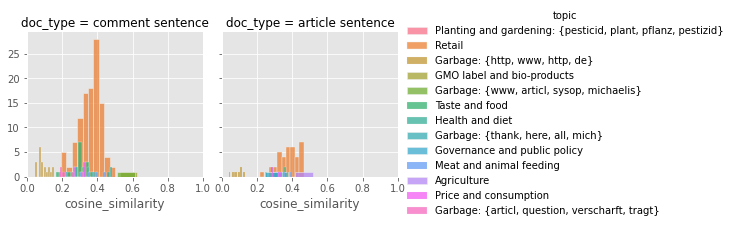

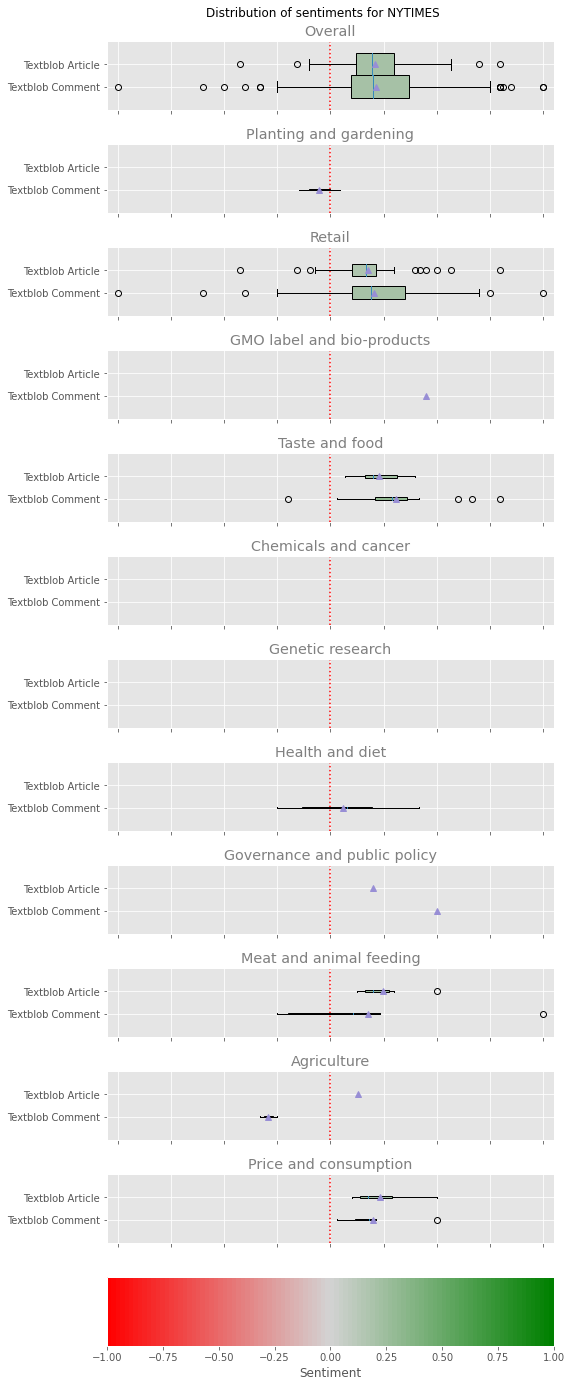

In [ ]:
get_topic_distribution_by_article(source = Source.NYTIMES, article_id = article_id)

### SPIEGEL - 39

In [ ]:
article_id = 39
print(spiegel.iloc[article_id].article_title)
print(spiegel.iloc[article_id].article_url)

Biosupermarkt | US-Wirtschaftskrise killt Ökogelüste
http://www.spiegel.de/wirtschaft/biosupermarkt-us-wirtschaftskrise-killt-oekogelueste-a-572904.html


For spiegel: 150 articles, 61 with comments


cluster  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               comment_sentence_id_list
0         0  ...  [141883, 141894, 141968, 142025, 142026, 142030, 142033, 142037, 142040, 142069, 142070, 142077, 142078, 142080, 142085, 142087, 142091, 142094, 142135, 142166, 142317, 142423, 142440, 142460, 142507, 142517, 142580, 142621, 142701, 142725, 142739, 142742, 142807, 142875, 142950, 142951, 143016, 143017, 143020, 143038, 143039, 143047, 143108, 143154, 143160, 143194, 143271, 143292, 143293, 143320, 143444, 143455, 143475, 143568, 143628, 143634, 143647, 143746, 143806, 143809, 143811, 143883, 143909, 143925, 143926, 143930, 143932, 143934, 143963, 143969, 143971, 144009, 144010, 144013, 144027, 144054, 144062, 144065, 144067, 144078, 144090, 144097, 144100, 144101, 144129, 144132, 144136, 144214, 144216, 144227, 144231, 144250, 144309, 144329, 144332, 144337, 144392, 144412, 144501, 144554, ...]
1         1  ...                                                                                                                                                                                                                                                                                                                                       [141922, 141974, 141975, 142053, 142054, 142103, 142113, 142121, 142175, 142181, 142182, 142187, 142206, 142207, 142211, 142213, 142215, 142242, 142306, 142415, 142416, 142489, 142630, 142747, 143067, 143542, 143681, 143683, 143728, 143729, 143732, 143764, 143766, 143835, 143838, 143839, 144151, 144592, 144611, 144623, 144625, 144628, 144667, 144720, 144817, 144829, 144937, 145368, 145430, 145458, 145489, 145522, 145656, 145663, 146073, 146108, 146119, 146145, 146749, 146766]
2         2  ...  [141855, 141953, 141993, 142044, 142185, 142212, 142246, 142290, 142390, 142397, 142402, 142403, 142418, 142493, 142530, 142635, 142754, 142757, 142800, 142842, 142901, 142929, 142974, 142989, 142994, 143074, 143237, 143247, 143334, 143404, 143415, 143436, 143481, 143500, 143523, 143527, 143605, 143617, 143621, 143653, 143678, 143680, 143682, 143686, 143701, 143704, 143718, 143750, 143761, 143765, 143781, 143796, 143846, 143882, 144188, 144218, 144449, 144472, 144480, 144503, 144533, 144536, 144659, 144699, 144874, 144884, 145067, 145072, 145084, 145103, 145112, 145126, 145151, 145169, 145182, 145204, 145212, 145363, 145484, 145595, 145619, 145669, 145672, 145690, 145772, 145786, 145798, 145822, 145839, 146099, 146177, 146362, 146446, 146493, 146505, 146530, 146559, 146563, 146632, 146688, ...]
3         3  ...  [141862, 141870, 141897, 141904, 141925, 141939, 141940, 141996, 142002, 142004, 142006, 142021, 142023, 142049, 142063, 142066, 142190, 142209, 142274, 142275, 142278, 142279, 142280, 142284, 142285, 142310, 142311, 142312, 142319, 142330, 142332, 142343, 142351, 142352, 142353, 142367, 142430, 142434, 142459, 142463, 142472, 142614, 142655, 142676, 142694, 142825, 142968, 142997, 143010, 143397, 143412, 143413, 143417, 143433, 143438, 143498, 143517, 143591, 143612, 143613, 143614, 143636, 143716, 143722, 143724, 143725, 143740, 143743, 143754, 143799, 143801, 143802, 143804, 143805, 143916, 143975, 144014, 144028, 144031, 144043, 144049, 144060, 144069, 144117, 144133, 144196, 1

source  article_id  ... sentence_id  cosine_similarity
5     spiegel          39  ...      142030           0.585062
7     spiegel          39  ...      142037           0.585062
0     spiegel          39  ...      141883           0.579851
96    spiegel          39  ...      144392           0.579156
82    spiegel          39  ...      144100           0.572816
42    spiegel          39  ...      143108           0.570887
33    spiegel          39  ...      142875           0.570887
60    spiegel          39  ...      143811           0.568958
13    spiegel          39  ...      142080           0.565638
54    spiegel          39  ...      143628           0.564053
23    spiegel          39  ...      142460           0.563688
103   spiegel          39  ...      144686           0.562790
102   spiegel          39  ...      144681           0.562790
2     spiegel          39  ...      141968           0.557938
1     spiegel          39  ...      141894           0.557938
18    spiegel          39  ...      142135           0.555877
16    spiegel          39  ...      142091           0.555877
126   spiegel          39  ...      145692           0.553753
122   spiegel          39  ...      145621           0.553753
14    spiegel          39  ...      142085           0.547652
59    spiegel          39  ...      143809           0.545862
78    spiegel          39  ...      144067           0.540552
132   spiegel          39  ...      145732           0.539476
24    spiegel          39  ...      142507           0.536131
36    spiegel          39  ...      143016           0.535464
39    spiegel          39  ...      143038           0.535464
120   spiegel          39  ...      145594           0.530625
64    spiegel          39  ...      143926           0.528535
15    spiegel          39  ...      142087           0.528440
30    spiegel          39  ...      142739           0.528201
27    spiegel          39  ...      142621           0.528201
58    spiegel          39  ...      143806           0.527732
133   spiegel          39  ...      145768           0.526910
90    spiegel          39  ...      144231           0.526117
93    spiegel          39  ...      144329           0.526117
45    spiegel          39  ...      143194           0.525541
11    spiegel          39  ...      142077           0.524139
9     spiegel          39  ...      142069           0.524139
92    spiegel          39  ...      144309           0.522543
89    spiegel          39  ...      144227           0.522543
163   spiegel          39  ...      146730           0.522429
141   spiegel          39  ...      146231           0.521593
73    spiegel          39  ...      144013           0.518980
87    spiegel          39  ...      144214           0.516771
124   spiegel          39  ...      145636           0.516177
127   spiegel          39  ...      145706           0.516177
161   spiegel          39  ...      146722           0.515437
148   spiegel          39  ...      146291           0.514345
147   spiegel          39  ...      146261           0.514345
142   spiegel          39  ...      146241           0.513782
145   spiegel          39  ...      146251           0.513782
129   spiegel          39  ...      145721           0.509495
83    spiegel          39  ...      144101           0.508682
146   spiegel          39  ...      146256           0.508222
143   spiegel          39  ...      146242           0.508222
51    spiegel          39  ...      143455           0.506756
53    spiegel          39  ...      143568           0.506756
31    spiegel          39  ...      142742           0.503738
41    spiegel          39  ...      143047           0.502870
72    spiegel          39  ...      144010           0.502612
69    spiegel          39  ...      143969           0.502378
67    spiegel          39  ...      143934           0.502378
116   spiegel          39  ...      145538           0.501714
71    spiegel          39  ...      144

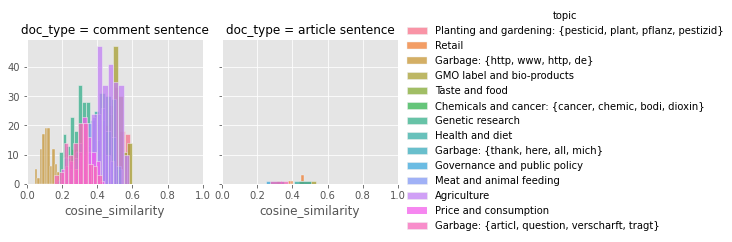

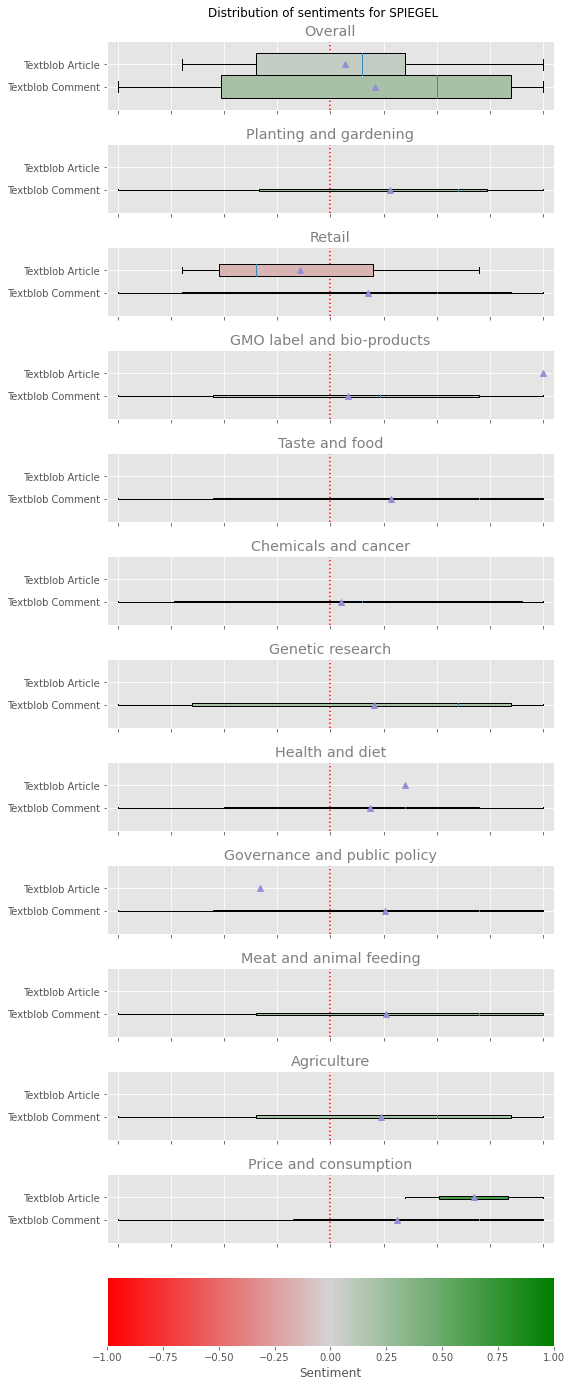

In [ ]:
get_topic_distribution_by_article(source = Source.SPIEGEL, article_id = article_id)

## GMO 

### NYTIMES - 175

In [ ]:
article_id = 175
display(nytimes.iloc[article_id].article_title)
display(nytimes.iloc[article_id].article_url)

'Major Grocer to Label Foods With Gene-Modified Content'

'http://www.nytimes.com/2013/03/09/business/grocery-chain-to-require-labels-for-genetically-modified-food.html'

For nytimes: 327 articles, 99 with comments


cluster  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           comment_sentence_id_list
0         0  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       [26822, 27019, 27055, 27072, 27074, 27077, 27078, 27128, 27129, 27134, 27182, 27194, 27197, 27231, 27238, 27250, 27295, 27380, 27382, 27532]
1         1  ...                                                                                                                                                   [26704, 26705, 26709, 26728, 26751, 26768, 26777, 26778, 26798, 26855, 26861, 26862, 26867, 26868, 26871, 26872, 26875, 26877, 26879, 26883, 26896, 26941, 26972, 26993, 26998, 27001, 27003, 27006, 27010, 27014, 27018, 27024, 27068, 27096, 27102, 27103, 27123, 27138, 27148, 27151, 27158, 27188, 27212, 27214, 27221, 27241, 27306, 27307, 27310, 27313, 27314, 27316, 27317, 27320, 27324, 27331, 27332, 27366, 27368, 27369, 27393, 27403, 27415, 27420, 27427, 27431, 27440, 27441, 27449, 27456, 27459, 27462, 27478, 27485, 27540, 27559, 27567, 27571, 27574, 27586]
2         2  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            [26718, 26719, 26740, 26779, 26832, 26992, 27007, 27015, 27116, 27399, 27432, 27445, 27486, 27496, 27503, 27524, 27577]
3         3  ...  [26695, 26696, 26702, 26703, 26706, 26743, 26745, 26749, 26753, 26763, 26765, 26781, 26794, 26801, 26802, 26803, 26816, 26817, 26818, 26821, 26825, 26827, 26836, 26837, 26838, 26843, 26844, 26856, 26888, 26889, 26903, 26907, 26914, 26924, 26940, 26947, 26957, 26960, 26961, 26965, 26976, 26985, 26997, 27011, 27016, 27017, 27021, 27026, 27033, 27037, 27044, 27051, 27053, 27070, 27080, 27086, 27088, 27095, 27099, 27100, 27104, 27105, 27110, 27111, 27117, 27118, 27132, 27141, 27142, 27143, 27153, 27155, 27165, 27171, 27172, 27176, 27180, 27186, 27192, 27193, 27196, 27204, 27208, 27209, 27224, 27228, 27234, 27242, 27248, 27256, 27270, 27275, 27277, 27278, 27284, 27287, 27290, 27291, 27294, 27321, ...]
4         4  ...                                                                                                                                                                                                                                                                                                                                                                                

source  article_id  ... sentence_id  cosine_similarity
0    nytimes         175  ...       26644           0.512460
1    nytimes         175  ...       26645           0.420530
5    nytimes         175  ...       27072           0.575236
11   nytimes         175  ...       27134           0.559066
2    nytimes         175  ...       26822           0.535534
19   nytimes         175  ...       27380           0.534435
15   nytimes         175  ...       27231           0.529456
17   nytimes         175  ...       27250           0.517861
13   nytimes         175  ...       27194           0.515372
7    nytimes         175  ...       27077           0.498284
18   nytimes         175  ...       27295           0.496888
16   nytimes         175  ...       27238           0.482585
4    nytimes         175  ...       27055           0.463040
3    nytimes         175  ...       27019           0.444872
6    nytimes         175  ...       27074           0.438071
8    nytimes         175  ...       27078           0.431175
14   nytimes         175  ...       27197           0.426435
21   nytimes         175  ...       27532           0.423838
12   nytimes         175  ...       27182           0.420800
10   nytimes         175  ...       27129           0.409290
9    nytimes         175  ...       27128           0.403224
20   nytimes         175  ...       27382           0.397505
33   nytimes         175  ...       26686           0.485854
30   nytimes         175  ...       26679           0.480405
31   nytimes         175  ...       26680           0.434603
26   nytimes         175  ...       26651           0.423938
35   nytimes         175  ...       26688           0.400944
32   nytimes         175  ...       26682           0.400173
22   nytimes         175  ...       26638           0.395201
23   nytimes         175  ...       26639           0.391311
29   nytimes         175  ...       26672           0.381952
25   nytimes         175  ...       26648           0.375205
34   nytimes         175  ...       26687           0.364780
24   nytimes         175  ...       26646           0.352123
28   nytimes         175  ...       26662           0.333426
27   nytimes         175  ...       26657           0.314630
64   nytimes         175  ...       27010           0.491422
87   nytimes         175  ...       27316           0.479175
71   nytimes         175  ...       27103           0.476715
74   nytimes         175  ...       27148           0.473132
82   nytimes         175  ...       27306           0.463794
45   nytimes         175  ...       26855           0.463256
90   nytimes         175  ...       27324           0.460915
105  nytimes         175  ...       27456           0.454653
101  nytimes         175  ...       27431           0.453284
100  nytimes         175  ...       27427           0.452306
66   nytimes         175  ...       27018           0.449006
65   nytimes         175  ...       27014           0.442940
94   nytimes         175  ...       27368           0.442837
89   nytimes         175  ...       27320           0.440096
51   nytimes         175  ...       26872           0.438581
91   nytimes         175  ...       27331           0.437707
40   nytimes         175  ...       26751           0.433367
42   nytimes         175  ...       26777           0.429007
98   nytimes         175  ...       27415           0.426553
36   nytimes         175  ...       26704           0.424447
102  nytimes         175  ...       27440           0.421968
37   nytimes         175  ...       26705           0.421180
54   nytimes         175  ...       26879           0.418266
75   nytimes         175  ...       27151           0.418163
84   nytimes         175  ...       27310           0.417342
113  nytimes         175  ...       27571           0.417316
79   nytimes         175  ...       27214           0.417103
77   nytimes         175  ...       27188           0.416445
96   nytimes         175  ...       27393

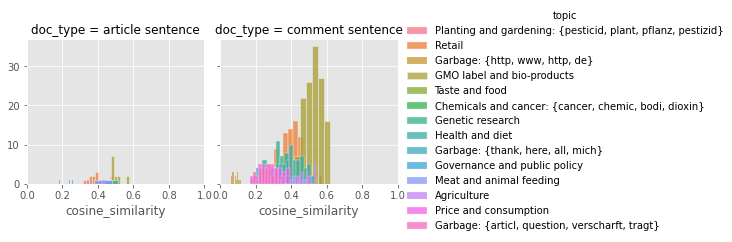

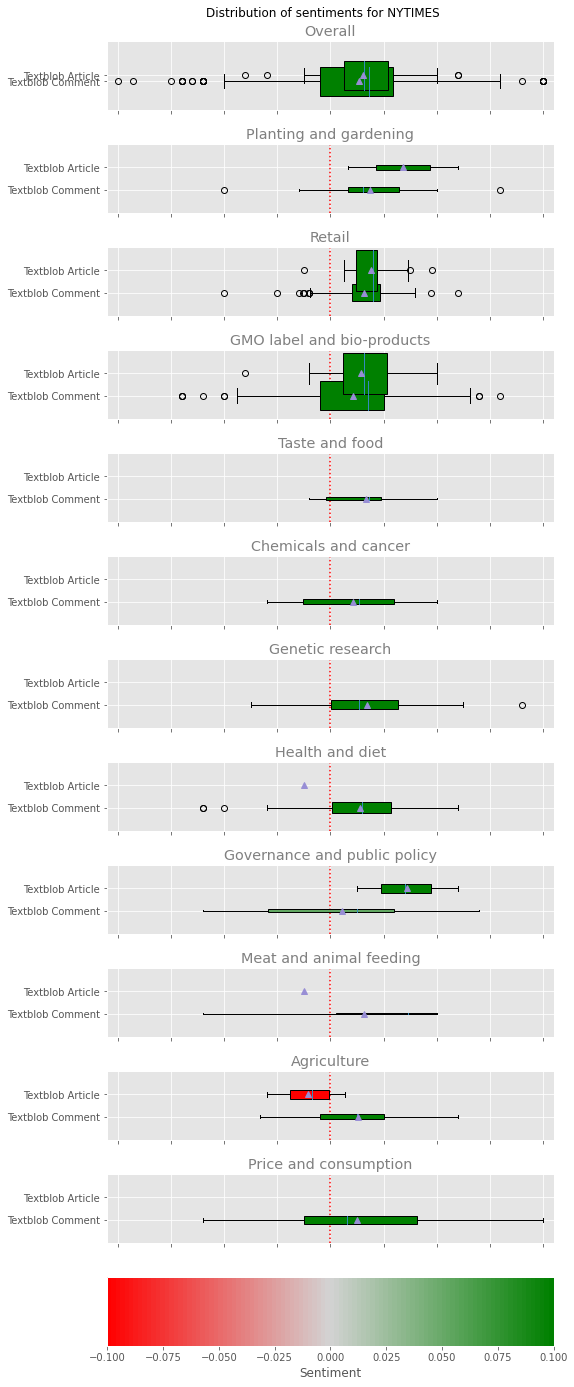

In [ ]:
get_topic_distribution_by_article(source = Source.NYTIMES, article_id = article_id)

For nytimes: 327 articles, 99 with comments


cluster  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           comment_sentence_id_list
0         0  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       [26822, 27019, 27055, 27072, 27074, 27077, 27078, 27128, 27129, 27134, 27182, 27194, 27197, 27231, 27238, 27250, 27295, 27380, 27382, 27532]
1         1  ...                                                                                                                                                   [26704, 26705, 26709, 26728, 26751, 26768, 26777, 26778, 26798, 26855, 26861, 26862, 26867, 26868, 26871, 26872, 26875, 26877, 26879, 26883, 26896, 26941, 26972, 26993, 26998, 27001, 27003, 27006, 27010, 27014, 27018, 27024, 27068, 27096, 27102, 27103, 27123, 27138, 27148, 27151, 27158, 27188, 27212, 27214, 27221, 27241, 27306, 27307, 27310, 27313, 27314, 27316, 27317, 27320, 27324, 27331, 27332, 27366, 27368, 27369, 27393, 27403, 27415, 27420, 27427, 27431, 27440, 27441, 27449, 27456, 27459, 27462, 27478, 27485, 27540, 27559, 27567, 27571, 27574, 27586]
2         2  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            [26718, 26719, 26740, 26779, 26832, 26992, 27007, 27015, 27116, 27399, 27432, 27445, 27486, 27496, 27503, 27524, 27577]
3         3  ...  [26695, 26696, 26702, 26703, 26706, 26743, 26745, 26749, 26753, 26763, 26765, 26781, 26794, 26801, 26802, 26803, 26816, 26817, 26818, 26821, 26825, 26827, 26836, 26837, 26838, 26843, 26844, 26856, 26888, 26889, 26903, 26907, 26914, 26924, 26940, 26947, 26957, 26960, 26961, 26965, 26976, 26985, 26997, 27011, 27016, 27017, 27021, 27026, 27033, 27037, 27044, 27051, 27053, 27070, 27080, 27086, 27088, 27095, 27099, 27100, 27104, 27105, 27110, 27111, 27117, 27118, 27132, 27141, 27142, 27143, 27153, 27155, 27165, 27171, 27172, 27176, 27180, 27186, 27192, 27193, 27196, 27204, 27208, 27209, 27224, 27228, 27234, 27242, 27248, 27256, 27270, 27275, 27277, 27278, 27284, 27287, 27290, 27291, 27294, 27321, ...]
4         4  ...                                                                                                                                                                                                                                                                                                                                                                                

source  article_id  ... sentence_id  cosine_similarity
0    nytimes         175  ...       26644           0.512460
1    nytimes         175  ...       26645           0.420530
5    nytimes         175  ...       27072           0.575236
11   nytimes         175  ...       27134           0.559066
2    nytimes         175  ...       26822           0.535534
19   nytimes         175  ...       27380           0.534435
15   nytimes         175  ...       27231           0.529456
17   nytimes         175  ...       27250           0.517861
13   nytimes         175  ...       27194           0.515372
7    nytimes         175  ...       27077           0.498284
18   nytimes         175  ...       27295           0.496888
16   nytimes         175  ...       27238           0.482585
4    nytimes         175  ...       27055           0.463040
3    nytimes         175  ...       27019           0.444872
6    nytimes         175  ...       27074           0.438071
8    nytimes         175  ...       27078           0.431175
14   nytimes         175  ...       27197           0.426435
21   nytimes         175  ...       27532           0.423838
12   nytimes         175  ...       27182           0.420800
10   nytimes         175  ...       27129           0.409290
9    nytimes         175  ...       27128           0.403224
20   nytimes         175  ...       27382           0.397505
33   nytimes         175  ...       26686           0.485854
30   nytimes         175  ...       26679           0.480405
31   nytimes         175  ...       26680           0.434603
26   nytimes         175  ...       26651           0.423938
35   nytimes         175  ...       26688           0.400944
32   nytimes         175  ...       26682           0.400173
22   nytimes         175  ...       26638           0.395201
23   nytimes         175  ...       26639           0.391311
29   nytimes         175  ...       26672           0.381952
25   nytimes         175  ...       26648           0.375205
34   nytimes         175  ...       26687           0.364780
24   nytimes         175  ...       26646           0.352123
28   nytimes         175  ...       26662           0.333426
27   nytimes         175  ...       26657           0.314630
64   nytimes         175  ...       27010           0.491422
87   nytimes         175  ...       27316           0.479175
71   nytimes         175  ...       27103           0.476715
74   nytimes         175  ...       27148           0.473132
82   nytimes         175  ...       27306           0.463794
45   nytimes         175  ...       26855           0.463256
90   nytimes         175  ...       27324           0.460915
105  nytimes         175  ...       27456           0.454653
101  nytimes         175  ...       27431           0.453284
100  nytimes         175  ...       27427           0.452306
66   nytimes         175  ...       27018           0.449006
65   nytimes         175  ...       27014           0.442940
94   nytimes         175  ...       27368           0.442837
89   nytimes         175  ...       27320           0.440096
51   nytimes         175  ...       26872           0.438581
91   nytimes         175  ...       27331           0.437707
40   nytimes         175  ...       26751           0.433367
42   nytimes         175  ...       26777           0.429007
98   nytimes         175  ...       27415           0.426553
36   nytimes         175  ...       26704           0.424447
102  nytimes         175  ...       27440           0.421968
37   nytimes         175  ...       26705           0.421180
54   nytimes         175  ...       26879           0.418266
75   nytimes         175  ...       27151           0.418163
84   nytimes         175  ...       27310           0.417342
113  nytimes         175  ...       27571           0.417316
79   nytimes         175  ...       27214           0.417103
77   nytimes         175  ...       27188           0.416445
96   nytimes         175  ...       27393

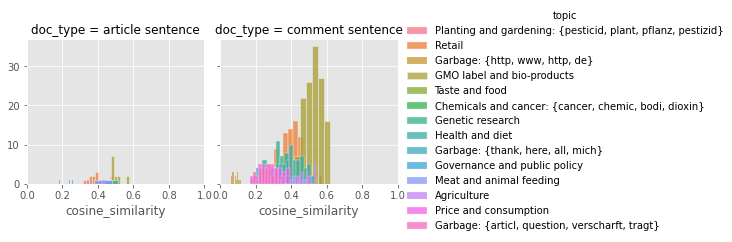

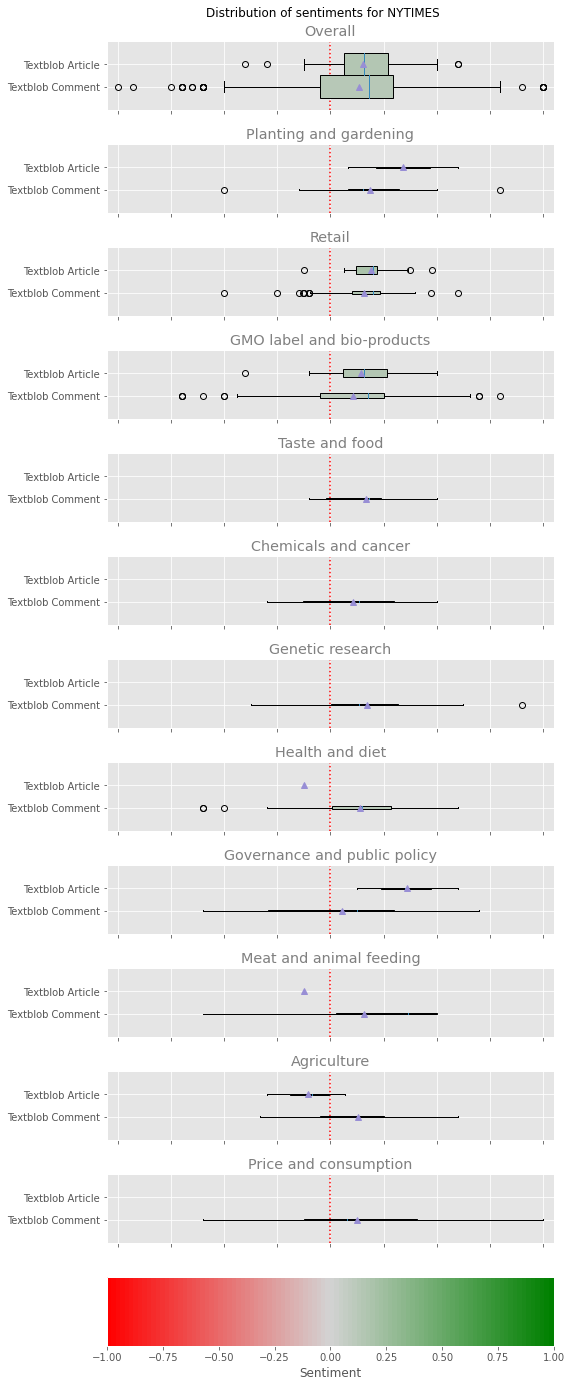

In [ ]:
get_topic_distribution_by_article(source = Source.NYTIMES, article_id = article_id)

### SPIEGEL - 142

In [ ]:
article_id = 142
print(spiegel.iloc[article_id].article_title)
print(spiegel.iloc[article_id].article_url)

Ernährung | Biolebensmittel kaum gesünder als normale Produkte
http://www.spiegel.de/gesundheit/ernaehrung/bioprodukte-sind-kaum-gesuender-als-konventionelle-lebensmittel-a-853617.html


For spiegel: 150 articles, 61 with comments


cluster  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               comment_sentence_id_list
0         0  ...                                                                       [349720, 349721, 349814, 349861, 349869, 349891, 349894, 349963, 350025, 350097, 350141, 350160, 350202, 350236, 350282, 350291, 350487, 350536, 350538, 350608, 350611, 350613, 350615, 350633, 350701, 350726, 350763, 350819, 350915, 350917, 350969, 350981, 351004, 351007, 351051, 351067, 351090, 351125, 351138, 351206, 351207, 351208, 351220, 351275, 351340, 351349, 351431, 351476, 351518, 351551, 351573, 351589, 351628, 351629, 351644, 351677, 351741, 351775, 351795, 351832, 351848, 351901, 351902, 351914, 351926, 351960, 351972, 352053, 352177, 352256, 352330, 352405, 352471, 352494, 352561, 352569, 352629, 352661, 352665, 352803, 352826, 352836, 352839, 352874, 352971, 352972, 353049, 353055, 353060, 353128, 353176, 353189]
1         1  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       [349857, 350091, 350139, 350493, 350497, 350555, 350561, 350646, 350881, 351025, 351039, 351373, 351632, 351633, 351636, 352366, 352387, 352492, 352579, 352590, 352645, 352652]
2         2  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       [349801, 350035, 350090, 350174, 350184, 350310, 350315, 350317, 350333, 350453, 350702, 350820, 351002, 351374, 351502, 351780, 351805, 351836, 351852, 352170, 352241, 352286, 352296, 352309, 352315, 352408, 352451, 352477, 352489, 352504, 352506, 352531, 352535, 352592, 352693, 352703, 352829, 352924]
3         3  ...  [349694, 349711, 349717, 349722, 349730, 349744, 349745, 349750, 349754, 349758, 349773, 349776, 349791, 349797, 349807, 349813, 349822, 349848, 349856, 349866, 349870, 349871, 349873, 349917, 349931, 349940, 349945, 349947, 349950, 349951, 349954, 349962, 349982, 349991, 350016, 350017, 350019, 350062, 350105, 350135, 350159, 350163, 350173, 350180, 350195, 350221, 350222, 350225, 350227, 350255, 350262, 350277, 350289, 350313, 350326, 350332, 350336, 350347, 350356, 350365, 350366, 350368, 350377, 350379, 350383, 350385, 350391, 350417, 350418, 350422, 350423, 350426, 350429, 350441, 350490, 350492, 350498, 350510, 350517, 350524, 350550, 350566, 350567, 350571, 350602, 350603, 3

source  article_id  ... sentence_id  cosine_similarity
0     spiegel         142  ...      349666           0.571974
1     spiegel         142  ...      349667           0.502294
37    spiegel         142  ...      351067           0.588769
17    spiegel         142  ...      350291           0.587675
42    spiegel         142  ...      351207           0.584907
38    spiegel         142  ...      351090           0.582531
44    spiegel         142  ...      351220           0.580251
74    spiegel         142  ...      352471           0.580251
33    spiegel         142  ...      350981           0.580251
87    spiegel         142  ...      352972           0.577172
49    spiegel         142  ...      351476           0.572367
63    spiegel         142  ...      351901           0.571974
57    spiegel         142  ...      351677           0.567572
22    spiegel         142  ...      350611           0.563525
30    spiegel         142  ...      350915           0.555179
9     spiegel         142  ...      349963           0.549944
43    spiegel         142  ...      351208           0.548053
10    spiegel         142  ...      350025           0.541500
21    spiegel         142  ...      350608           0.540669
54    spiegel         142  ...      351628           0.539840
2     spiegel         142  ...      349720           0.539840
41    spiegel         142  ...      351206           0.538512
20    spiegel         142  ...      350538           0.530312
47    spiegel         142  ...      351349           0.524900
48    spiegel         142  ...      351431           0.523764
50    spiegel         142  ...      351518           0.522312
68    spiegel         142  ...      351972           0.519731
8     spiegel         142  ...      349894           0.516997
60    spiegel         142  ...      351795           0.512839
12    spiegel         142  ...      350141           0.512326
86    spiegel         142  ...      352971           0.511636
39    spiegel         142  ...      351125           0.508137
34    spiegel         142  ...      351004           0.505416
59    spiegel         142  ...      351775           0.502452
58    spiegel         142  ...      351741           0.502452
64    spiegel         142  ...      351902           0.502294
7     spiegel         142  ...      349891           0.502294
32    spiegel         142  ...      350969           0.499426
28    spiegel         142  ...      350763           0.499426
16    spiegel         142  ...      350282           0.499426
5     spiegel         142  ...      349861           0.496230
23    spiegel         142  ...      350613           0.494805
11    spiegel         142  ...      350097           0.494410
72    spiegel         142  ...      352330           0.493773
91    spiegel         142  ...      353128           0.492699
55    spiegel         142  ...      351629           0.485274
3     spiegel         142  ...      349721           0.485274
51    spiegel         142  ...      351551           0.485270
56    spiegel         142  ...      351644           0.481177
24    spiegel         142  ...      350615           0.479514
18    spiegel         142  ...      350487           0.478785
81    spiegel         142  ...      352803           0.476360
93    spiegel         142  ...      353189           0.474307
71    spiegel         142  ...      352256           0.472014
85    spiegel         142  ...      352874           0.470583
6     spiegel         142  ...      349869           0.469389
83    spiegel         142  ...      352836           0.466809
80    spiegel         142  ...      352665           0.466660
4     spiegel         142  ...      349814           0.463904
69    spiegel         142  ...      352053           0.461755
61    spiegel         142  ...      351832           0.461755
66    spiegel         142  ...      351926           0.461755
19    spiegel         142  ...      350536           0.458770
62    spiegel         142  ...      351

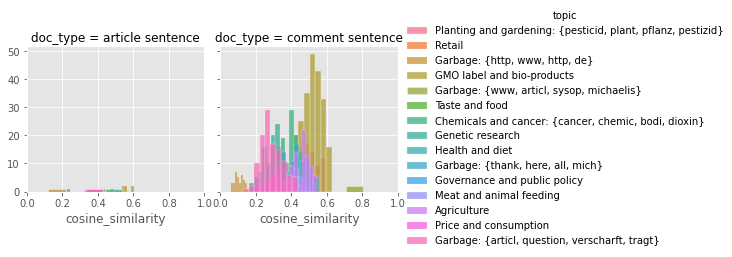

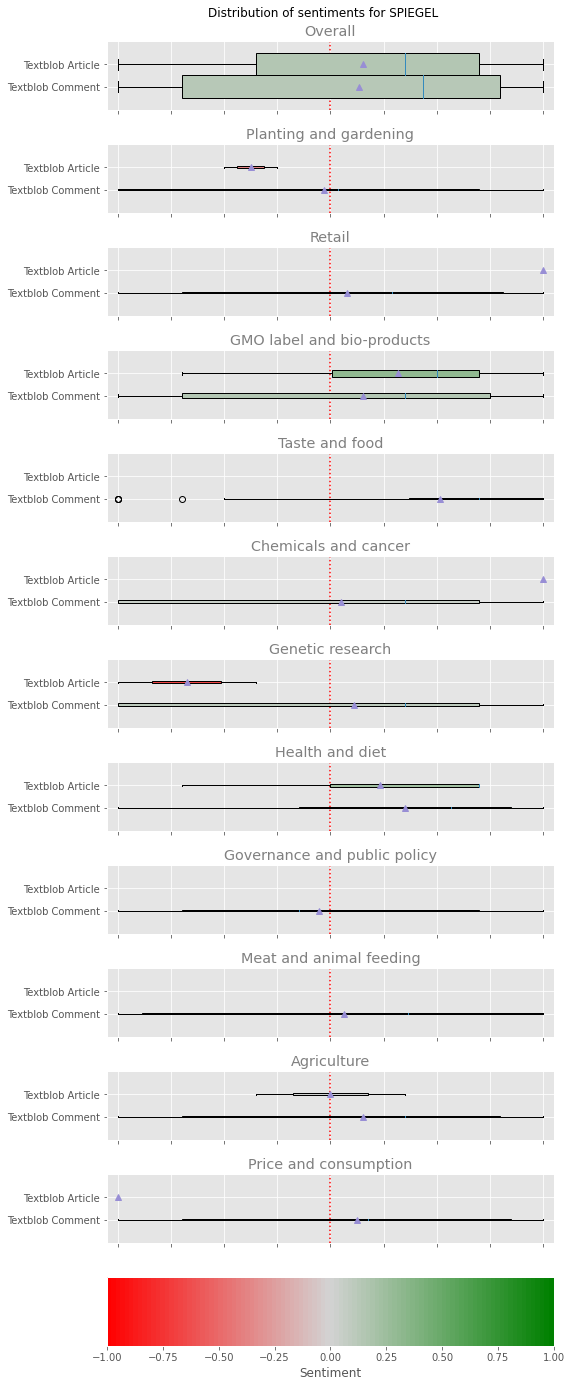

In [ ]:
get_topic_distribution_by_article(source = Source.SPIEGEL, article_id = article_id)

### SPIEGEL - 59

In [ ]:
article_id = 59
print(spiegel.iloc[article_id].article_title)
print(spiegel.iloc[article_id].article_url)

BioFach-Messe | Umstrittener Weg zur Bio-Republik
http://www.spiegel.de/wirtschaft/biofach-messe-umstrittener-weg-zur-bio-republik-a-609028.html


For spiegel: 150 articles, 61 with comments


cluster  ...                                                                                                                                                                                                                                                                                                                                                                                                          comment_sentence_id_list
0         0  ...                                                                                                                                                                                                                          [193966, 193995, 194054, 194140, 194501, 194503, 194520, 194530, 194557, 194559, 194597, 194628, 194630, 194660, 194680, 194704, 194720, 194734, 194751, 194754, 194771, 194783, 194800, 194803, 194871]
1         1  ...                                                                                                                                                                                                                                                                                                  [193983, 194079, 194080, 194087, 194109, 194112, 194114, 194179, 194297, 194308, 194365, 194888, 194902, 194905, 194922, 194927]
2         2  ...                                                                                                                                                                                                                  [193914, 193987, 194104, 194113, 194129, 194150, 194225, 194234, 194266, 194307, 194310, 194377, 194436, 194620, 194695, 194712, 194719, 194739, 194788, 194834, 194853, 194854, 194938, 194950, 194981, 194986]
3         3  ...                                                          [193912, 193919, 193939, 193940, 193958, 193991, 194142, 194144, 194288, 194317, 194326, 194333, 194371, 194390, 194391, 194392, 194395, 194396, 194410, 194418, 194443, 194447, 194459, 194466, 194484, 194500, 194514, 194523, 194564, 194568, 194569, 194577, 194610, 194637, 194646, 194663, 194683, 194689, 194690, 194708, 194742, 194791, 194876, 194879, 194913]
4         4  ...                                                                                                                                                                                                                                                                                                                                                                                                                               NaN
5         5  ...                                                                                                                                                                                                          [193969, 193972, 194009, 194097, 194124, 194162, 194187, 194254, 194290, 194291, 194296, 194305, 194335, 194367, 194393, 194492, 194544, 194558, 194600, 194604, 194607, 194626, 194717, 194725, 194801, 194868, 194936]
6         6  ...                                                                                                                                                                                                                                                                                                                                                  [193920, 194096, 194098, 194099, 194100, 194159, 194541, 194575, 194619, 194770]
7         7  ...                                                                                                                                                                          [193893, 193905, 193930, 193944, 193953, 193963, 194048, 194073, 194107, 194169, 194244, 194258, 194302, 194361, 194464, 194482, 194499, 194510, 194562, 194570, 194584, 194588, 194598, 194622, 194732, 194745, 194763, 194794, 194817, 194840, 194899]
8         8  ...                                                                         

source  article_id  ... sentence_id  cosine_similarity
18   spiegel          59  ...      194751           0.579425
22   spiegel          59  ...      194800           0.579425
4    spiegel          59  ...      194501           0.534019
24   spiegel          59  ...      194871           0.534019
13   spiegel          59  ...      194660           0.530747
5    spiegel          59  ...      194503           0.505668
8    spiegel          59  ...      194557           0.469988
7    spiegel          59  ...      194530           0.450579
12   spiegel          59  ...      194630           0.449823
1    spiegel          59  ...      193995           0.440642
2    spiegel          59  ...      194054           0.440642
0    spiegel          59  ...      193966           0.440642
20   spiegel          59  ...      194771           0.431989
11   spiegel          59  ...      194628           0.426980
21   spiegel          59  ...      194783           0.424341
17   spiegel          59  ...      194734           0.414099
3    spiegel          59  ...      194140           0.404583
14   spiegel          59  ...      194680           0.400415
15   spiegel          59  ...      194704           0.400415
19   spiegel          59  ...      194754           0.395072
23   spiegel          59  ...      194803           0.395072
9    spiegel          59  ...      194559           0.391945
16   spiegel          59  ...      194720           0.372752
10   spiegel          59  ...      194597           0.350322
6    spiegel          59  ...      194520           0.350322
25   spiegel          59  ...      193840           0.356101
39   spiegel          59  ...      194905           0.399490
38   spiegel          59  ...      194902           0.399490
30   spiegel          59  ...      194109           0.384486
37   spiegel          59  ...      194888           0.384432
40   spiegel          59  ...      194922           0.384432
29   spiegel          59  ...      194087           0.382595
31   spiegel          59  ...      194112           0.378959
28   spiegel          59  ...      194080           0.376513
33   spiegel          59  ...      194179           0.357782
26   spiegel          59  ...      193983           0.357782
32   spiegel          59  ...      194114           0.335502
41   spiegel          59  ...      194927           0.333609
27   spiegel          59  ...      194079           0.271281
35   spiegel          59  ...      194308           0.263452
34   spiegel          59  ...      194297           0.255341
36   spiegel          59  ...      194365           0.227230
42   spiegel          59  ...      193854           0.189225
43   spiegel          59  ...      193867           0.140134
53   spiegel          59  ...      194307           0.173158
65   spiegel          59  ...      194854           0.165318
60   spiegel          59  ...      194719           0.157854
59   spiegel          59  ...      194712           0.157647
52   spiegel          59  ...      194266           0.146212
48   spiegel          59  ...      194129           0.144345
49   spiegel          59  ...      194150           0.144345
63   spiegel          59  ...      194834           0.140470
64   spiegel          59  ...      194853           0.137057
58   spiegel          59  ...      194695           0.135400
67   spiegel          59  ...      194950           0.123440
69   spiegel          59  ...      194986           0.123440
47   spiegel          59  ...      194113           0.121514
46   spiegel          59  ...      194104           0.120852
68   spiegel          59  ...      194981           0.119951
66   spiegel          59  ...      194938           0.112254
45   spiegel          59  ...      193987           0.111961
55   spiegel          59  ...      194377           0.108960
62   spiegel          59  ...      194788           0.106135
61   spiegel          59  ...      194739           0.106135
56   spiegel          59  ...      194436

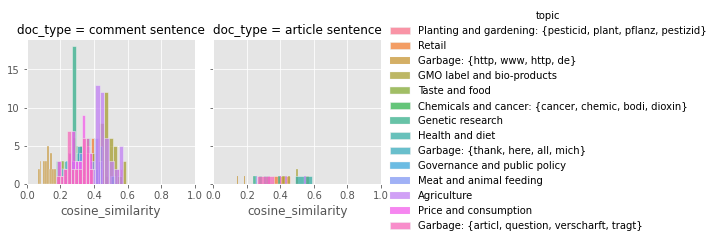

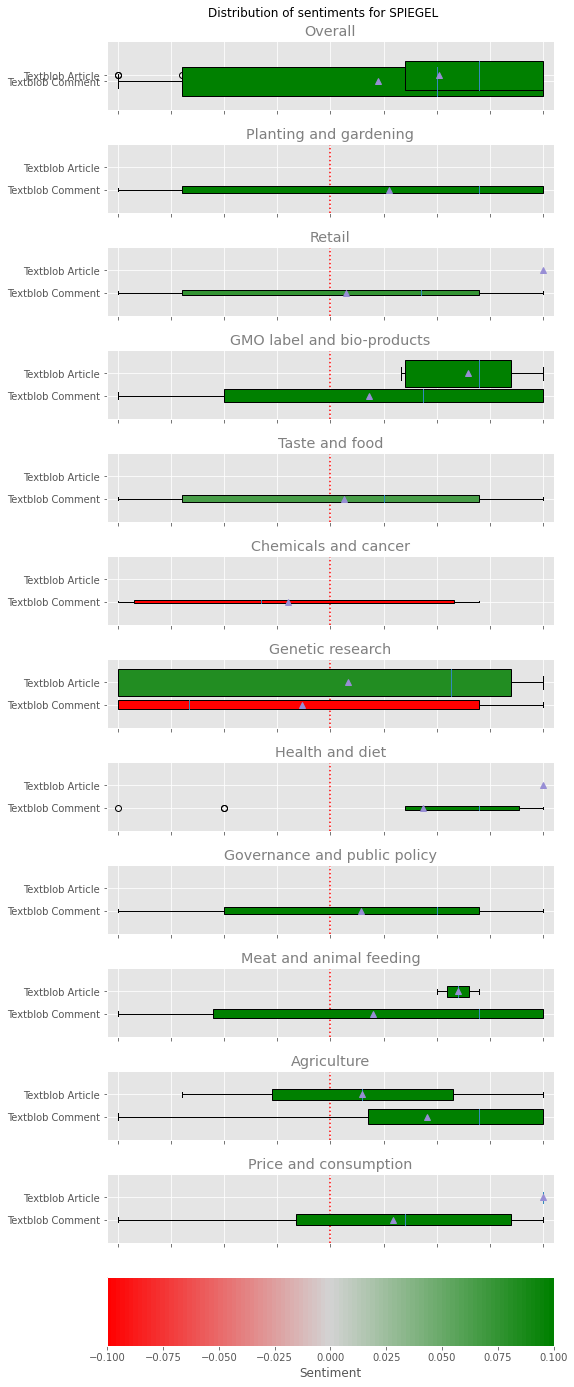

In [ ]:
get_topic_distribution_by_article(source = Source.SPIEGEL, article_id = article_id)

### SPIEGEL - 92

In [ ]:
article_id = 92
print(spiegel.iloc[article_id].article_title)
print(spiegel.iloc[article_id].article_url)

"Öko-Test" und Co. | Welche Lebensmittelsiegel wirklich taugen
http://www.spiegel.de/wirtschaft/service/oeko-test-und-co-welche-lebensmittelsiegel-wirklich-taugen-a-813556.html


For spiegel: 150 articles, 61 with comments


cluster  ...                                                                                                                                                                                                                                                          comment_sentence_id_list
0         0  ...                                                                                                                                                                                                                                                                          [270098]
1         1  ...                                                                                                                                                                                                  [269877, 269954, 269971, 270156, 270189, 270208, 270256, 270310, 270356, 270361]
2         2  ...                                                          [269832, 269842, 269848, 269856, 269876, 269884, 269965, 269980, 269986, 269989, 269997, 270011, 270026, 270038, 270052, 270067, 270070, 270112, 270116, 270126, 270204, 270226, 270248, 270262, 270271, 270316, 270365]
3         3  ...  [269831, 269847, 269855, 269888, 269892, 269904, 269918, 269933, 269951, 269994, 270020, 270037, 270055, 270081, 270083, 270084, 270086, 270133, 270149, 270153, 270163, 270168, 270171, 270182, 270183, 270192, 270193, 270203, 270215, 270240, 270243, 270245, 270270, 270332]
4         4  ...                                                                                                                                                                                                                                                                          [270290]
5         5  ...                                                                          [269859, 269942, 269961, 269962, 269978, 269985, 270018, 270022, 270023, 270031, 270040, 270043, 270050, 270076, 270082, 270085, 270103, 270105, 270174, 270176, 270253, 270255, 270263, 270299, 270331]
6         6  ...                                                                                                                                                                                                                                                          [270078, 270150, 270172]
7         7  ...                                                                                                                          [269850, 269851, 269852, 269865, 269872, 269908, 270048, 270051, 270061, 270063, 270110, 270120, 270162, 270191, 270210, 270217, 270229, 270231, 270237]
8         8  ...                                                                                                                                                  [269874, 269920, 269981, 269993, 270017, 270027, 270093, 270249, 270259, 270265, 270291, 270304, 270305, 270309, 270314, 270315]
9         9  ...                                                                                                                                                                          [269834, 269881, 269882, 269883, 269902, 269945, 270280, 270312, 270363, 270371, 270392, 270397, 270399]
10       10  ...                                                                                                                                                                                                                                                  [269889, 269905, 270154, 270190]
11       11  ...                                                                                                                                                                                                                          [270135, 270239, 270260, 270272, 270282, 270374, 270379]
12       12  ...                                                                                                                                                                                          [269931, 269967, 26

source  article_id  ... sentence_id  cosine_similarity
0    spiegel          92  ...      270098           0.496861
1    spiegel          92  ...      269816           0.403867
2    spiegel          92  ...      269822           0.339820
3    spiegel          92  ...      269828           0.264296
9    spiegel          92  ...      270208           0.422827
6    spiegel          92  ...      269971           0.419678
5    spiegel          92  ...      269954           0.419678
7    spiegel          92  ...      270156           0.415640
10   spiegel          92  ...      270256           0.307669
4    spiegel          92  ...      269877           0.304682
13   spiegel          92  ...      270361           0.303405
12   spiegel          92  ...      270356           0.303405
8    spiegel          92  ...      270189           0.298939
11   spiegel          92  ...      270310           0.264250
14   spiegel          92  ...      269815           0.123696
16   spiegel          92  ...      269842           0.157252
23   spiegel          92  ...      269986           0.149663
40   spiegel          92  ...      270316           0.147665
41   spiegel          92  ...      270365           0.147553
25   spiegel          92  ...      269997           0.138385
33   spiegel          92  ...      270116           0.137819
34   spiegel          92  ...      270126           0.137819
32   spiegel          92  ...      270112           0.132096
21   spiegel          92  ...      269965           0.127436
26   spiegel          92  ...      270011           0.127436
24   spiegel          92  ...      269989           0.127436
28   spiegel          92  ...      270038           0.123696
15   spiegel          92  ...      269832           0.123696
17   spiegel          92  ...      269848           0.123696
18   spiegel          92  ...      269856           0.123696
35   spiegel          92  ...      270204           0.123696
39   spiegel          92  ...      270271           0.123696
20   spiegel          92  ...      269884           0.114399
36   spiegel          92  ...      270226           0.108862
29   spiegel          92  ...      270052           0.107949
30   spiegel          92  ...      270067           0.102238
31   spiegel          92  ...      270070           0.102104
37   spiegel          92  ...      270248           0.094349
22   spiegel          92  ...      269980           0.094349
27   spiegel          92  ...      270026           0.094349
19   spiegel          92  ...      269876           0.094216
38   spiegel          92  ...      270262           0.033714
43   spiegel          92  ...      269817           0.476066
44   spiegel          92  ...      269823           0.433385
42   spiegel          92  ...      269814           0.396097
54   spiegel          92  ...      269994           0.604955
52   spiegel          92  ...      269933           0.562350
48   spiegel          92  ...      269888           0.553149
61   spiegel          92  ...      270086           0.532912
65   spiegel          92  ...      270163           0.510915
64   spiegel          92  ...      270153           0.505308
50   spiegel          92  ...      269904           0.505308
76   spiegel          92  ...      270245           0.498049
78   spiegel          92  ...      270332           0.494868
66   spiegel          92  ...      270168           0.492487
71   spiegel          92  ...      270193           0.487824
60   spiegel          92  ...      270084           0.485627
51   spiegel          92  ...      269918           0.468396
69   spiegel          92  ...      270183           0.457630
70   spiegel          92  ...      270192           0.456747
59   spiegel          92  ...      270083           0.446847
67   spiegel          92  ...      270171           0.427396
63   spiegel          92  ...      270149           0.427396
68   spiegel          92  ...      270182           0.410957
58   spiegel          92  ...      270081

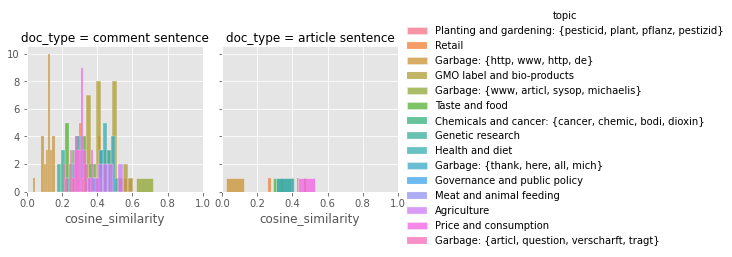

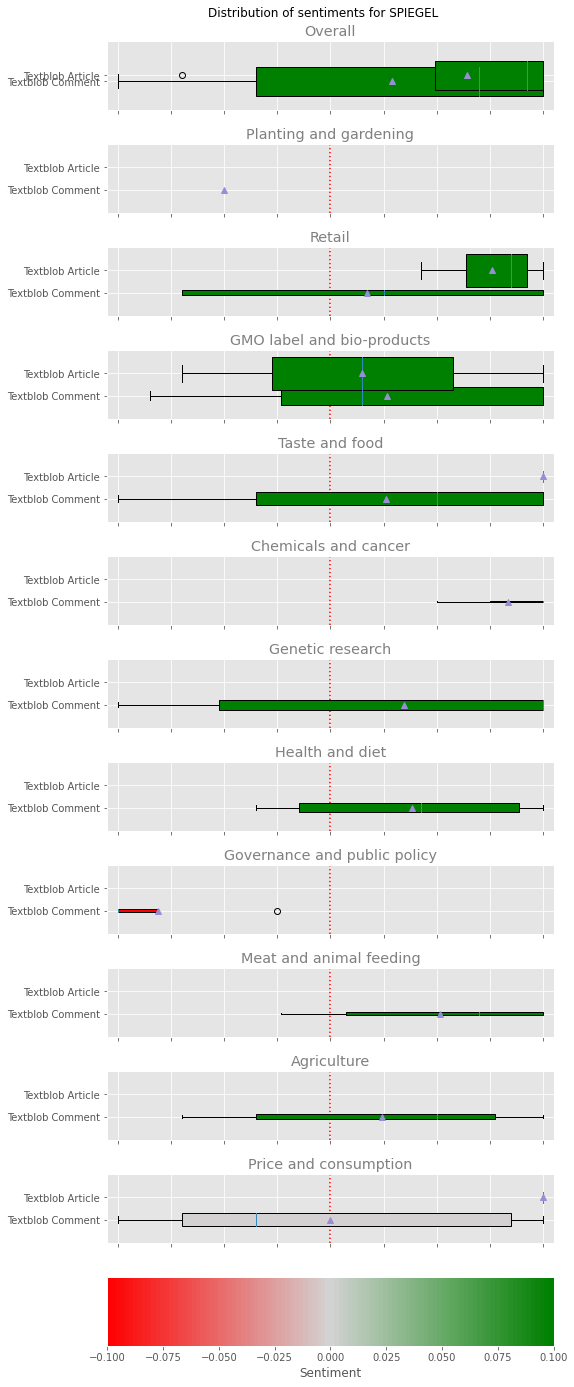

In [ ]:
get_topic_distribution_by_article(source = Source.SPIEGEL, article_id = article_id)

# References

### NYTIMES - 243

In [ ]:
article_id = 243
display(nytimes.iloc[article_id])

article_title                                  The Compost King of New York
article_author                 [{'article_author_name': 'ELIZABETH ROYTE'}]
article_time                                            2017-02-15 00:00:00
article_text              On an overcast winter morning, Charles Vigliot...
article_source                                                     NY Times
comments                  [{'comment_id': '21487468', 'comment_author': ...
search_query                                                   organic food
article_url               https://www.nytimes.com/2017/02/15/magazine/th...
resource_type                                                     editorial
relevant                                                                  1
processed_article_text    On an overcast winter morning, Charles Vigliot...
Name: 342, dtype: object

For nytimes: 327 articles, 99 with comments


cluster  ...                                                                                                                                                                comment_sentence_id_list
0         0  ...  [46158, 46160, 46165, 46235, 46240, 46243, 46246, 46251, 46269, 46274, 46285, 46294, 46312, 46313, 46339, 46342, 46353, 46358, 46366, 46367, 46368, 46372, 46384, 46407, 46409, 46411]
1         1  ...                                                                                                    [46167, 46168, 46204, 46239, 46253, 46254, 46256, 46273, 46295, 46314, 46338, 46394]
2         2  ...                                                                               [46200, 46219, 46220, 46237, 46259, 46261, 46279, 46392, 46396, 46397, 46398, 46399, 46415, 46418, 46423]
3         3  ...                                                                                                                                                                          [46214, 46283]
4         4  ...                                                                                                                                                                                     NaN
5         5  ...                                            [46189, 46242, 46267, 46272, 46290, 46296, 46299, 46301, 46305, 46307, 46308, 46309, 46311, 46315, 46335, 46343, 46350, 46351, 46426, 46427]
6         6  ...                                                                                                                                                                   [46195, 46196, 46249]
7         7  ...                                                                                                                  [46211, 46216, 46233, 46316, 46324, 46327, 46405, 46417, 46424, 46425]
8         8  ...                                                                               [46198, 46201, 46224, 46263, 46264, 46268, 46289, 46302, 46303, 46329, 46336, 46344, 46386, 46393, 46408]
9         9  ...                                                                                      [46177, 46227, 46282, 46321, 46323, 46325, 46333, 46346, 46347, 46377, 46382, 46390, 46395, 46402]
10       10  ...                                                                                                           [46179, 46185, 46208, 46231, 46241, 46266, 46278, 46330, 46373, 46381, 46422]
11       11  ...                                                                                                                                                                                     NaN
12       12  ...  [46190, 46199, 46213, 46215, 46232, 46252, 46255, 46257, 46270, 46287, 46288, 46304, 46317, 46332, 46354, 46357, 46359, 46378, 46383, 46388, 46412, 46419, 46428, 46429, 46430, 46431]
13       13  ...                                                                                                                         [46162, 46171, 46236, 46262, 46284, 46291, 46297, 46322, 46328]
14       14  ...                                                                                                                  [46193, 46207, 46258, 46326, 46375, 46379, 46385, 46406, 46420, 46421]

[15 rows x 10 columns]

source  article_id  ... sentence_id  cosine_similarity
13   nytimes         243  ...       46102           0.538092
8    nytimes         243  ...       46065           0.513997
3    nytimes         243  ...       46022           0.495469
9    nytimes         243  ...       46084           0.463859
0    nytimes         243  ...       46018           0.463272
2    nytimes         243  ...       46020           0.456758
4    nytimes         243  ...       46023           0.444932
1    nytimes         243  ...       46019           0.418761
14   nytimes         243  ...       46133           0.403082
10   nytimes         243  ...       46085           0.400156
5    nytimes         243  ...       46052           0.359451
6    nytimes         243  ...       46053           0.359219
12   nytimes         243  ...       46097           0.351493
11   nytimes         243  ...       46087           0.347326
7    nytimes         243  ...       46060           0.319952
25   nytimes         243  ...       46285           0.515799
28   nytimes         243  ...       46313           0.513509
36   nytimes         243  ...       46372           0.509079
40   nytimes         243  ...       46411           0.488549
39   nytimes         243  ...       46409           0.488119
38   nytimes         243  ...       46407           0.485198
17   nytimes         243  ...       46165           0.480992
29   nytimes         243  ...       46339           0.469788
24   nytimes         243  ...       46274           0.464325
20   nytimes         243  ...       46243           0.463412
35   nytimes         243  ...       46368           0.456174
30   nytimes         243  ...       46342           0.443191
27   nytimes         243  ...       46312           0.425262
21   nytimes         243  ...       46246           0.424313
34   nytimes         243  ...       46367           0.423272
32   nytimes         243  ...       46358           0.420902
23   nytimes         243  ...       46269           0.412400
26   nytimes         243  ...       46294           0.399144
33   nytimes         243  ...       46366           0.395037
31   nytimes         243  ...       46353           0.343400
18   nytimes         243  ...       46235           0.329591
16   nytimes         243  ...       46160           0.323720
37   nytimes         243  ...       46384           0.320599
19   nytimes         243  ...       46240           0.310913
22   nytimes         243  ...       46251           0.278293
15   nytimes         243  ...       46158           0.271886
50   nytimes         243  ...       46126           0.369608
41   nytimes         243  ...       46036           0.367189
46   nytimes         243  ...       46070           0.320945
49   nytimes         243  ...       46125           0.283671
45   nytimes         243  ...       46059           0.275486
48   nytimes         243  ...       46074           0.271981
43   nytimes         243  ...       46054           0.257225
44   nytimes         243  ...       46056           0.233984
42   nytimes         243  ...       46044           0.222153
47   nytimes         243  ...       46071           0.206406
55   nytimes         243  ...       46253           0.379776
62   nytimes         243  ...       46394           0.343372
59   nytimes         243  ...       46295           0.343028
60   nytimes         243  ...       46314           0.336691
52   nytimes         243  ...       46168           0.322399
51   nytimes         243  ...       46167           0.314879
58   nytimes         243  ...       46273           0.304474
56   nytimes         243  ...       46254           0.269757
53   nytimes         243  ...       46204           0.259342
57   nytimes         243  ...       46256           0.253416
61   nytimes         243  ...       46338           0.222123
54   nytimes         243  ...       46239           0.207233
64   nytimes         243  ...       46011           0.158555
77   nytimes         243  ...       46122

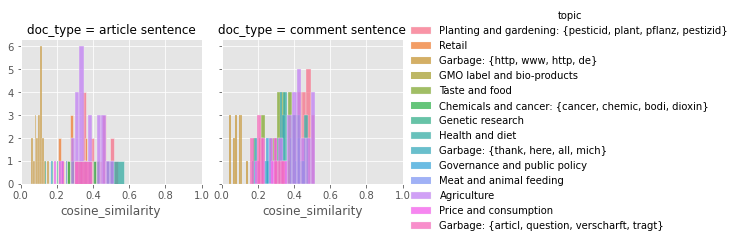

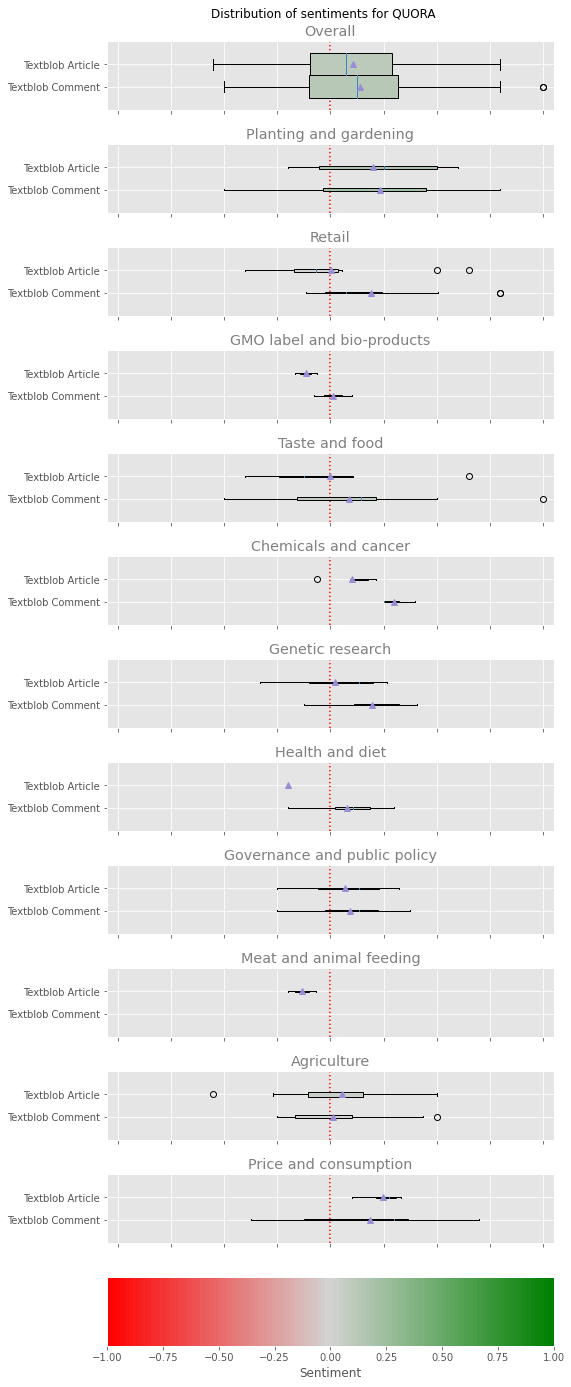

In [ ]:
get_topic_distribution_by_article(source = Source.NYTIMES, article_id = article_id)

### NYTIMES - 200

In [ ]:
article_id = 200
nytimes.iloc[article_id]

article_title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

For nytimes: 327 articles, 99 with comments


cluster  ... comment_sentence_id_list
0         0  ...                      NaN
1         1  ...                      NaN
2         2  ...                      NaN
3         3  ...                      NaN
4         4  ...                      NaN
5         5  ...                      NaN
6         6  ...                      NaN
7         7  ...                      NaN
8         8  ...                      NaN
9         9  ...                      NaN
10       10  ...                      NaN
11       11  ...                      NaN
12       12  ...                      NaN
13       13  ...                      NaN
14       14  ...                      NaN

[15 rows x 10 columns]

source  article_id  ... sentence_id  cosine_similarity
2   nytimes         200  ...       33666           0.461088
4   nytimes         200  ...       33668           0.452884
8   nytimes         200  ...       33678           0.435481
18  nytimes         200  ...       33695           0.432962
23  nytimes         200  ...       33703           0.401113
6   nytimes         200  ...       33670           0.396510
7   nytimes         200  ...       33671           0.379279
10  nytimes         200  ...       33682           0.376975
15  nytimes         200  ...       33690           0.373724
19  nytimes         200  ...       33696           0.372084
1   nytimes         200  ...       33665           0.356493
11  nytimes         200  ...       33686           0.356212
0   nytimes         200  ...       33664           0.350260
12  nytimes         200  ...       33687           0.341857
3   nytimes         200  ...       33667           0.338213
9   nytimes         200  ...       33680           0.335833
17  nytimes         200  ...       33693           0.329502
21  nytimes         200  ...       33698           0.326591
5   nytimes         200  ...       33669           0.303646
22  nytimes         200  ...       33701           0.289138
14  nytimes         200  ...       33689           0.288133
16  nytimes         200  ...       33692           0.278197
13  nytimes         200  ...       33688           0.223918
20  nytimes         200  ...       33697           0.216790
24  nytimes         200  ...       33691           0.110781
25  nytimes         200  ...       33679           0.464274
26  nytimes         200  ...       33681           0.411294

[27 rows x 8 columns]

ZeroDivisionError: ignored

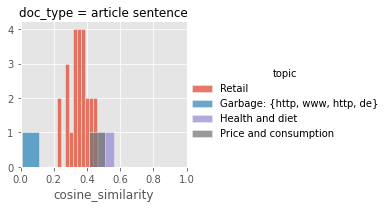

In [ ]:
get_topic_distribution_by_article(source = Source.NYTIMES, article_id = article_id)

### SPIEGEL - 59

In [ ]:
article_id = 59
print(spiegel.iloc[article_id].article_title)
print(spiegel.iloc[article_id].article_url)

BioFach-Messe | Umstrittener Weg zur Bio-Republik
http://www.spiegel.de/wirtschaft/biofach-messe-umstrittener-weg-zur-bio-republik-a-609028.html


For spiegel: 150 articles, 61 with comments


cluster  ...                                                                                                                                                                                                                                                                                                                                                                                                          comment_sentence_id_list
0         0  ...                                                                                                                                                                                                                          [193966, 193995, 194054, 194140, 194501, 194503, 194520, 194530, 194557, 194559, 194597, 194628, 194630, 194660, 194680, 194704, 194720, 194734, 194751, 194754, 194771, 194783, 194800, 194803, 194871]
1         1  ...                                                                                                                                                                                                                                                                                                  [193983, 194079, 194080, 194087, 194109, 194112, 194114, 194179, 194297, 194308, 194365, 194888, 194902, 194905, 194922, 194927]
2         2  ...                                                                                                                                                                                                                  [193914, 193987, 194104, 194113, 194129, 194150, 194225, 194234, 194266, 194307, 194310, 194377, 194436, 194620, 194695, 194712, 194719, 194739, 194788, 194834, 194853, 194854, 194938, 194950, 194981, 194986]
3         3  ...                                                          [193912, 193919, 193939, 193940, 193958, 193991, 194142, 194144, 194288, 194317, 194326, 194333, 194371, 194390, 194391, 194392, 194395, 194396, 194410, 194418, 194443, 194447, 194459, 194466, 194484, 194500, 194514, 194523, 194564, 194568, 194569, 194577, 194610, 194637, 194646, 194663, 194683, 194689, 194690, 194708, 194742, 194791, 194876, 194879, 194913]
4         4  ...                                                                                                                                                                                                                                                                                                                                                                                                                               NaN
5         5  ...                                                                                                                                                                                                          [193969, 193972, 194009, 194097, 194124, 194162, 194187, 194254, 194290, 194291, 194296, 194305, 194335, 194367, 194393, 194492, 194544, 194558, 194600, 194604, 194607, 194626, 194717, 194725, 194801, 194868, 194936]
6         6  ...                                                                                                                                                                                                                                                                                                                                                  [193920, 194096, 194098, 194099, 194100, 194159, 194541, 194575, 194619, 194770]
7         7  ...                                                                                                                                                                          [193893, 193905, 193930, 193944, 193953, 193963, 194048, 194073, 194107, 194169, 194244, 194258, 194302, 194361, 194464, 194482, 194499, 194510, 194562, 194570, 194584, 194588, 194598, 194622, 194732, 194745, 194763, 194794, 194817, 194840, 194899]
8         8  ...                                                                         

source  article_id  ... sentence_id  cosine_similarity
18   spiegel          59  ...      194751           0.579425
22   spiegel          59  ...      194800           0.579425
4    spiegel          59  ...      194501           0.534019
24   spiegel          59  ...      194871           0.534019
13   spiegel          59  ...      194660           0.530747
5    spiegel          59  ...      194503           0.505668
8    spiegel          59  ...      194557           0.469988
7    spiegel          59  ...      194530           0.450579
12   spiegel          59  ...      194630           0.449823
1    spiegel          59  ...      193995           0.440642
2    spiegel          59  ...      194054           0.440642
0    spiegel          59  ...      193966           0.440642
20   spiegel          59  ...      194771           0.431989
11   spiegel          59  ...      194628           0.426980
21   spiegel          59  ...      194783           0.424341
17   spiegel          59  ...      194734           0.414099
3    spiegel          59  ...      194140           0.404583
14   spiegel          59  ...      194680           0.400415
15   spiegel          59  ...      194704           0.400415
19   spiegel          59  ...      194754           0.395072
23   spiegel          59  ...      194803           0.395072
9    spiegel          59  ...      194559           0.391945
16   spiegel          59  ...      194720           0.372752
10   spiegel          59  ...      194597           0.350322
6    spiegel          59  ...      194520           0.350322
25   spiegel          59  ...      193840           0.356101
39   spiegel          59  ...      194905           0.399490
38   spiegel          59  ...      194902           0.399490
30   spiegel          59  ...      194109           0.384486
37   spiegel          59  ...      194888           0.384432
40   spiegel          59  ...      194922           0.384432
29   spiegel          59  ...      194087           0.382595
31   spiegel          59  ...      194112           0.378959
28   spiegel          59  ...      194080           0.376513
33   spiegel          59  ...      194179           0.357782
26   spiegel          59  ...      193983           0.357782
32   spiegel          59  ...      194114           0.335502
41   spiegel          59  ...      194927           0.333609
27   spiegel          59  ...      194079           0.271281
35   spiegel          59  ...      194308           0.263452
34   spiegel          59  ...      194297           0.255341
36   spiegel          59  ...      194365           0.227230
42   spiegel          59  ...      193854           0.189225
43   spiegel          59  ...      193867           0.140134
53   spiegel          59  ...      194307           0.173158
65   spiegel          59  ...      194854           0.165318
60   spiegel          59  ...      194719           0.157854
59   spiegel          59  ...      194712           0.157647
52   spiegel          59  ...      194266           0.146212
48   spiegel          59  ...      194129           0.144345
49   spiegel          59  ...      194150           0.144345
63   spiegel          59  ...      194834           0.140470
64   spiegel          59  ...      194853           0.137057
58   spiegel          59  ...      194695           0.135400
67   spiegel          59  ...      194950           0.123440
69   spiegel          59  ...      194986           0.123440
47   spiegel          59  ...      194113           0.121514
46   spiegel          59  ...      194104           0.120852
68   spiegel          59  ...      194981           0.119951
66   spiegel          59  ...      194938           0.112254
45   spiegel          59  ...      193987           0.111961
55   spiegel          59  ...      194377           0.108960
62   spiegel          59  ...      194788           0.106135
61   spiegel          59  ...      194739           0.106135
56   spiegel          59  ...      194436

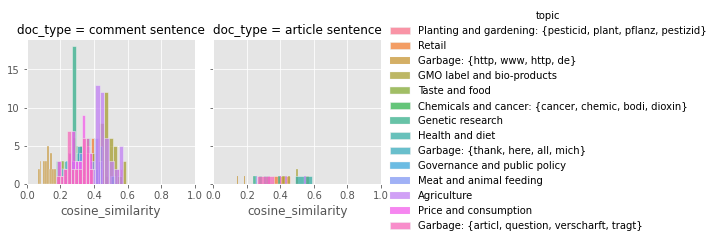

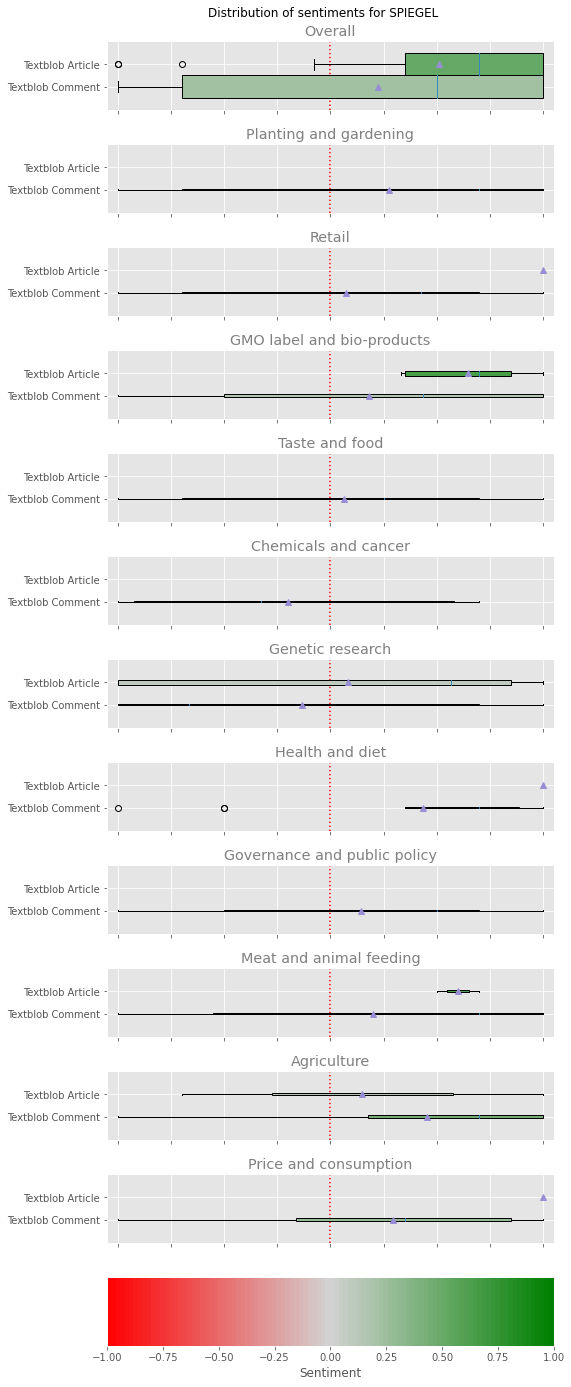

In [ ]:
get_topic_distribution_by_article(source = Source.SPIEGEL, article_id = article_id)

### SPIEGEL - 132

In [ ]:
article_id = 132
print(spiegel.iloc[article_id].article_title)
print(spiegel.iloc[article_id].article_url)

Übernahme: Schweizer Migros kauft süddeutsche Tegut
http://www.manager-magazin.de/unternehmen/handel/a-860849.html


For spiegel: 150 articles, 61 with comments


cluster  ... comment_sentence_id_list
0         0  ...                      NaN
1         1  ...                      NaN
2         2  ...                      NaN
3         3  ...                      NaN
4         4  ...                      NaN
5         5  ...                      NaN
6         6  ...                      NaN
7         7  ...                      NaN
8         8  ...                      NaN
9         9  ...                      NaN
10       10  ...                      NaN
11       11  ...                      NaN
12       12  ...                      NaN
13       13  ...                      NaN
14       14  ...                      NaN

[15 rows x 10 columns]

source  article_id  ... sentence_id  cosine_similarity
3  spiegel         132  ...      344322           0.435141
0  spiegel         132  ...      344308           0.391301
1  spiegel         132  ...      344310           0.371159
5  spiegel         132  ...      344332           0.319294
4  spiegel         132  ...      344330           0.306328
2  spiegel         132  ...      344314           0.274950
6  spiegel         132  ...      344324           0.387293

[7 rows x 8 columns]

ZeroDivisionError: ignored

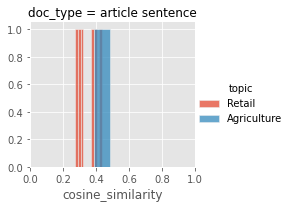

In [ ]:
get_topic_distribution_by_article(source = Source.SPIEGEL, article_id = article_id)